In [1]:
#.....                              Train with biased label (2 yr recidivism)

In [1]:
import pandas as pd
import json
import matplotlib.backends.backend_pdf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_curve, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay,precision_score, recall_score, roc_auc_score
from fairlearn.metrics import MetricFrame, selection_rate, equalized_odds_difference
from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.reductions import EqualizedOdds, ExponentiatedGradient
from sklearn.metrics import accuracy_score, roc_auc_score
from fairlearn.metrics import MetricFrame, selection_rate
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import random

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from fairlearn.metrics import (MetricFrame, selection_rate, true_positive_rate, false_positive_rate, demographic_parity_difference, equalized_odds_difference)

In [2]:
# Define the path to your CSV file
file_path ="C:/Users/ojoak/OneDrive - Danmarks Tekniske Universitet/2025/Facct/compas_scores.csv"

# Read the CSV file into a DataFrame
mydf = pd.read_csv(file_path)

In [3]:
mydf.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,vr_offense_date,vr_charge_desc,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,type_of_assessment,decile_score.1,score_text,screening_date
0,1,miguel hernandez,miguel,hernandez,14/08/2013,Male,18/04/1947,69,Greater than 45,Other,...,NaN,NaN,Risk of Violence,1,Low,14/08/2013,Risk of Recidivism,1,Low,14/08/2013
1,2,michael ryan,michael,ryan,31/12/2014,Male,06/02/1985,31,25 - 45,Caucasian,...,NaN,NaN,Risk of Violence,2,Low,31/12/2014,Risk of Recidivism,5,Medium,31/12/2014
2,3,kevon dixon,kevon,dixon,27/01/2013,Male,22/01/1982,34,25 - 45,African-American,...,05/07/2013,Felony Battery (Dom Strang),Risk of Violence,1,Low,27/01/2013,Risk of Recidivism,3,Low,27/01/2013
3,4,ed philo,ed,philo,14/04/2013,Male,14/05/1991,24,Less than 25,African-American,...,NaN,NaN,Risk of Violence,3,Low,14/04/2013,Risk of Recidivism,4,Low,14/04/2013
4,5,marcu brown,marcu,brown,13/01/2013,Male,21/01/1993,23,Less than 25,African-American,...,NaN,NaN,Risk of Violence,6,Medium,13/01/2013,Risk of Recidivism,8,High,13/01/2013


In [4]:
# Preprocess the data
mydf = mydf[(mydf['days_b_screening_arrest'] <= 30) & (mydf['days_b_screening_arrest'] >= -30)]
mydf = mydf[mydf['is_recid'] != -1]
mydf = mydf[mydf['c_charge_degree'] != 'O']
mydf = mydf[mydf['score_text'] != 'N/A']

In [5]:
# Merge Asian and Native American with others in the dataset
mydf['race'] = mydf['race'].replace(['Asian', 'Native American'], 'Other')


In [7]:
# Select features and target
features = ['age', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'c_charge_degree']
X = pd.get_dummies(mydf[features + ['race']], drop_first=False)  # Include race dummies as input features
y = (mydf['decile_score'] >= 5).astype(int)  # Set the target to 0 if decile score < 5, else 1

In [8]:
# Define the sensitive feature
sensitive_feature = mydf['race']

# Split the data
random.seed(42)
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = train_test_split(
    X, y, sensitive_feature, test_size=0.2, random_state=42)

In [9]:
# Train a gradient boosting model
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

GradientBoostingClassifier()

In [10]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Accuracy: 0.7465
ROC AUC: 0.8279


In [11]:

# Get confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Calculate metrics
tpr = tp / (tp + fn)  # True Positive Rate (Sensitivity or Recall)
fpr = fp / (fp + tn)  # False Positive Rate
fnr = fn / (fn + tp)  # False Negative Rate
tnr = tn / (tn + fp)  # True Negative Rate (Specificity)
ppv = tp / (tp + fp)  # Positive Predictive Value (Precision)
npv = tn / (tn + fn)  # Negative Predictive Value

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"TPR (Sensitivity or Recall): {tpr:.4f}")
print(f"FPR: {fpr:.4f}")
print(f"FNR: {fnr:.4f}")
print(f"TNR (Specificity): {tnr:.4f}")
print(f"PPV (Precision): {ppv:.4f}")
print(f"NPV: {npv:.4f}")

Accuracy: 0.7465
ROC AUC: 0.8279
TPR (Sensitivity or Recall): 0.6550
FPR: 0.1859
FNR: 0.3450
TNR (Specificity): 0.8141
PPV (Precision): 0.7220
NPV: 0.7619


In [12]:
# Evaluate fairness
metric_frame = MetricFrame(metrics={'accuracy': accuracy_score, 'selection_rate': selection_rate},
                           y_true=y_test,
                           y_pred=y_pred,
                           sensitive_features=sensitive_test)

print(metric_frame.by_group)

                  accuracy  selection_rate
race                                      
African-American  0.708820        0.586610
Caucasian         0.770671        0.205928
Hispanic          0.828221        0.134969
Other             0.796992        0.127820


In [13]:
# Define custom metrics
def tpr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp / (tp + fn)

def fpr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn)

def fnr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn / (fn + tp)

def tnr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

def ppv(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp / (tp + fp)

def npv(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fn)

def roc_auc(y_true, y_pred_proba): 
    return roc_auc_score(y_true, y_pred_proba)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluate fairness
metrics = {
    'accuracy': accuracy_score,
    'selection_rate': selection_rate,
    'tpr': tpr,
    'fpr': fpr,
    'fnr': fnr,
    'tnr': tnr,
    'ppv': ppv,
    'npv': npv,
    'roc_auc': roc_auc
}

metric_frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_test)

print(metric_frame.by_group)

                  accuracy  selection_rate       tpr       fpr       fnr  \
race                                                                       
African-American  0.708820        0.586610  0.771484  0.365967  0.228516   
Caucasian         0.770671        0.205928  0.465116  0.075117  0.534884   
Hispanic          0.828221        0.134969  0.421053  0.048000  0.578947   
Other             0.796992        0.127820  0.343750  0.059406  0.656250   

                       tnr       ppv       npv   roc_auc  
race                                                      
African-American  0.634033  0.715580  0.699229  0.702759  
Caucasian         0.924883  0.757576  0.774067  0.694999  
Hispanic          0.952000  0.727273  0.843972  0.686526  
Other             0.940594  0.647059  0.818966  0.642172  


In [14]:
from sklearn.metrics import (
    accuracy_score, 
    roc_auc_score, 
    confusion_matrix, 
    precision_score, 
    recall_score, 
    f1_score
)
from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate, true_negative_rate, false_positive_rate, false_negative_rate

# ... (your existing code for model training and prediction) ...

# Create a MetricFrame for comprehensive evaluation
metric_frame = MetricFrame(
    metrics={
        'accuracy': accuracy_score, 
        'selection_rate': selection_rate, 
        'TPR': true_positive_rate, 
        'TNR': true_negative_rate, 
        'FPR': false_positive_rate, 
        'FNR': false_negative_rate, 
        'PPV': precision_score, 
        'NPV': lambda y_true, y_pred: precision_score(y_true, y_pred, pos_label=0),
        'ROC AUC': roc_auc_score 
    },
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sensitive_test
)

# Print results by group
print(metric_frame.by_group)

                  accuracy  selection_rate       TPR       TNR       FPR  \
race                                                                       
African-American  0.708820        0.586610  0.771484  0.634033  0.365967   
Caucasian         0.770671        0.205928  0.465116  0.924883  0.075117   
Hispanic          0.828221        0.134969  0.421053  0.952000  0.048000   
Other             0.796992        0.127820  0.343750  0.940594  0.059406   

                       FNR       PPV       NPV   ROC AUC  
race                                                      
African-American  0.228516  0.715580  0.699229  0.702759  
Caucasian         0.534884  0.757576  0.774067  0.694999  
Hispanic          0.578947  0.727273  0.843972  0.686526  
Other             0.656250  0.647059  0.818966  0.642172  


In [15]:
# Mitigate bias using ThresholdOptimizer with Equalized Odds
threshold_optimizer = ThresholdOptimizer(estimator=model, constraints="equalized_odds", prefit=True)
threshold_optimizer.fit(X_train, y_train, sensitive_features=sensitive_train)
y_pred_mitigated = threshold_optimizer.predict(X_test, sensitive_features=sensitive_test)
y_pred_mitigated_proba = threshold_optimizer.predict(X_test, sensitive_features=sensitive_test)

In [176]:
# Mitigate bias using ThresholdOptimizer with Equalized Odds
threshold_optimizerT = ThresholdOptimizer(estimator=model, constraints="equalized_odds", prefit=True)
threshold_optimizerT.fit(X_train, y_train, sensitive_features=sensitive_train)
y_pred_mitigatedT = threshold_optimizerT.predict(X_train, sensitive_features=sensitive_train)
y_pred_mitigated_probaT = threshold_optimizerT.predict(X_train, sensitive_features=sensitive_train)

{
    "African-American": {
        "p_ignore": 0.077850174131901,
        "prediction_constant": 0.153,
        "p0": 0.6659000000000014,
        "operation0": "[>0.6317162098197183]",
        "p1": 0.3340999999999986,
        "operation1": "[>0.621532124228786]"
    },
    "Caucasian": {
        "p_ignore": 0.0,
        "prediction_constant": 0.153,
        "p0": 0.922153846153846,
        "operation0": "[>0.3806075260177546]",
        "p1": 0.07784615384615401,
        "operation1": "[>0.3795913949480643]"
    },
    "Hispanic": {
        "p_ignore": 0.12265552050740862,
        "prediction_constant": 0.153,
        "p0": 0.22721621621621638,
        "operation0": "[>0.4049338202819134]",
        "p1": 0.7727837837837837,
        "operation1": "[>0.3074052562067694]"
    },
    "Other": {
        "p_ignore": 0.20681617097636912,
        "prediction_constant": 0.153,
        "p0": 0.762200000000001,
        "operation0": "[>0.2586597383492427]",
        "p1": 0.237799999999999,
     

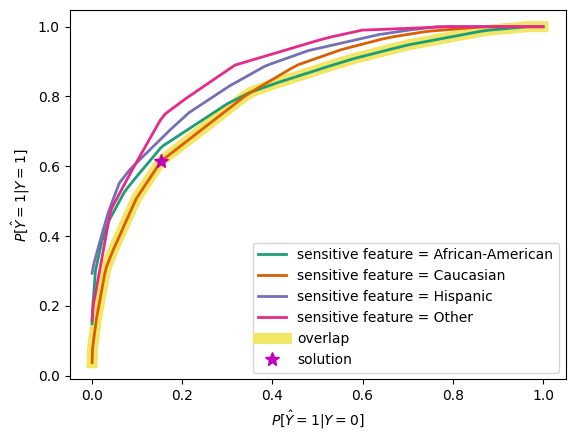

<Figure size 640x480 with 0 Axes>

In [16]:
print(
    json.dumps(
        threshold_optimizer.interpolated_thresholder_.interpolation_dict,
        default=str,
        indent=4,
    )
)
plot_threshold_optimizer(threshold_optimizer)

# Save the plot to a PDF file
pdf = matplotlib.backends.backend_pdf.PdfPages("Threshold1a.pdf")
pdf.savefig(plt.gcf())
pdf.close()

# Show the plot (optional)
plt.show()

In [17]:
# Evaluate the mitigated model
accuracy_mitigated = accuracy_score(y_test, y_pred_mitigated)
roc_auc_mitigated = roc_auc_score(y_test, y_pred_mitigated_proba)
#print(f"Mitigated Accuracy: {accuracy_mitigated:.2f}")

metric_frame_mitigated = MetricFrame(metrics={'accuracy': accuracy_score, 'selection_rate': selection_rate},
                                     y_true=y_test,
                                     y_pred=y_pred_mitigated,
                                     sensitive_features=sensitive_test)

print(f"Mitigated Accuracy: {accuracy_mitigated:.4f}")
print(f"Mitigated ROC AUC: {roc_auc_mitigated:.4f}")
print(metric_frame_mitigated.by_group)

Mitigated Accuracy: 0.7300
Mitigated ROC AUC: 0.7108
                  accuracy  selection_rate
race                                      
African-American  0.682253        0.415515
Caucasian         0.758190        0.305772
Hispanic          0.809816        0.276074
Other             0.834586        0.270677


In [18]:
# Get confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_mitigated).ravel()

# Calculate metrics
tpr = tp / (tp + fn)  # True Positive Rate (Sensitivity or Recall)
fpr = fp / (fp + tn)  # False Positive Rate
fnr = fn / (fn + tp)  # False Negative Rate
tnr = tn / (tn + fp)  # True Negative Rate (Specificity)
ppv = tp / (tp + fp)  # Positive Predictive Value (Precision)
npv = tn / (tn + fn)  # Negative Predictive Value

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_mitigated)
roc_auc = roc_auc_score(y_test, y_pred_mitigated_proba)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"TPR (Sensitivity or Recall): {tpr:.4f}")
print(f"FPR: {fpr:.4f}")
print(f"FNR: {fnr:.4f}")
print(f"TNR (Specificity): {tnr:.4f}")
print(f"PPV (Precision): {ppv:.4f}")
print(f"NPV: {npv:.4f}")

Accuracy: 0.7300
ROC AUC: 0.7108
TPR (Sensitivity or Recall): 0.6010
FPR: 0.1748
FNR: 0.3990
TNR (Specificity): 0.8252
PPV (Precision): 0.7171
NPV: 0.7372


In [19]:
from sklearn.metrics import (
    accuracy_score, 
    roc_auc_score, 
    confusion_matrix, 
    precision_score, 
    recall_score, 
    f1_score
)
from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate, true_negative_rate, false_positive_rate, false_negative_rate

# ... (existing code for model training and prediction) ...

# Create a MetricFrame for comprehensive evaluation
metric_frame_mitigated = MetricFrame(
    metrics={
        'accuracy': accuracy_score, 
        'selection_rate': selection_rate, 
        'TPR': true_positive_rate, 
        'TNR': true_negative_rate, 
        'FPR': false_positive_rate, 
        'FNR': false_negative_rate, 
        'PPV': precision_score, 
        'NPV': lambda y_true, y_pred: precision_score(y_true, y_pred, pos_label=0),
        'ROC AUC': roc_auc_score 
    },
    y_true=y_test,
    y_pred=y_pred_mitigated,
    sensitive_features=sensitive_test
)

# Print results by group
print(metric_frame_mitigated.by_group)

                  accuracy  selection_rate       TPR       TNR       FPR  \
race                                                                       
African-American  0.682253        0.415515  0.589844  0.792541  0.207459   
Caucasian         0.758190        0.305772  0.595349  0.840376  0.159624   
Hispanic          0.809816        0.276074  0.684211  0.848000  0.152000   
Other             0.834586        0.270677  0.718750  0.871287  0.128713   

                       FNR       PPV       NPV   ROC AUC  
race                                                      
African-American  0.410156  0.772379  0.618182  0.691192  
Caucasian         0.404651  0.653061  0.804494  0.717862  
Hispanic          0.315789  0.577778  0.898305  0.766105  
Other             0.281250  0.638889  0.907216  0.795019  


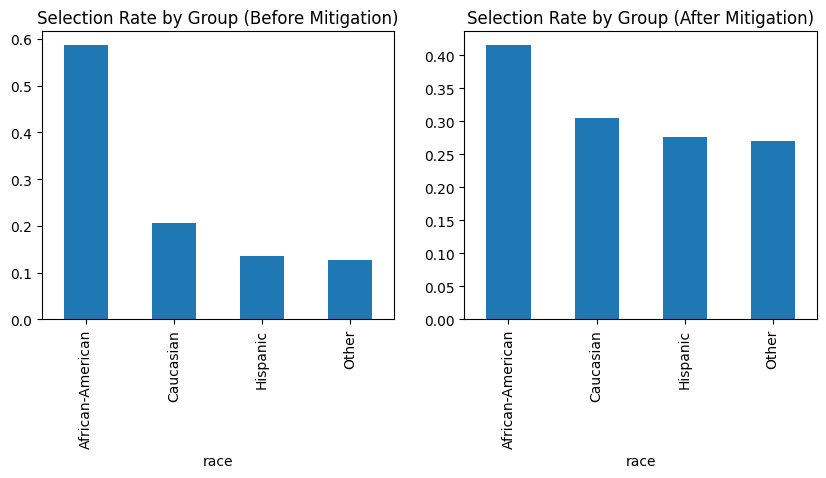

In [20]:
# Plot selection rate for each group before and after mitigation
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
metric_frame.by_group['selection_rate'].plot(kind='bar', ax=ax[0], title='Selection Rate by Group (Before Mitigation)')
metric_frame_mitigated.by_group['selection_rate'].plot(kind='bar', ax=ax[1], title='Selection Rate by Group (After Mitigation)')

# Save the plot to a PDF file
plt.subplots_adjust(bottom=0.4)
pdf = matplotlib.backends.backend_pdf.PdfPages("selection_case2aa.pdf")
pdf.savefig(plt.gcf())
pdf.close()

# Show the plot (optional)
plt.show()

C:\Users\ojoak\AppData\Local\Temp\ipykernel_24368\2402556021.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[0].vlines(x=metric_frame.by_group.index[i], ymin=0, ymax=metric_frame.by_group['selection_rate'][i], colors='b', linestyles='-',linewidth=2.5)
C:\Users\ojoak\AppData\Local\Temp\ipykernel_24368\2402556021.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[1].vlines(x=metric_frame_mitigated.by_group.index[i], ymin=0, ymax=metric_frame_mitigated.by_group['selection_rate'][i], colors='r', linestyles='-',linewidth=2.5)


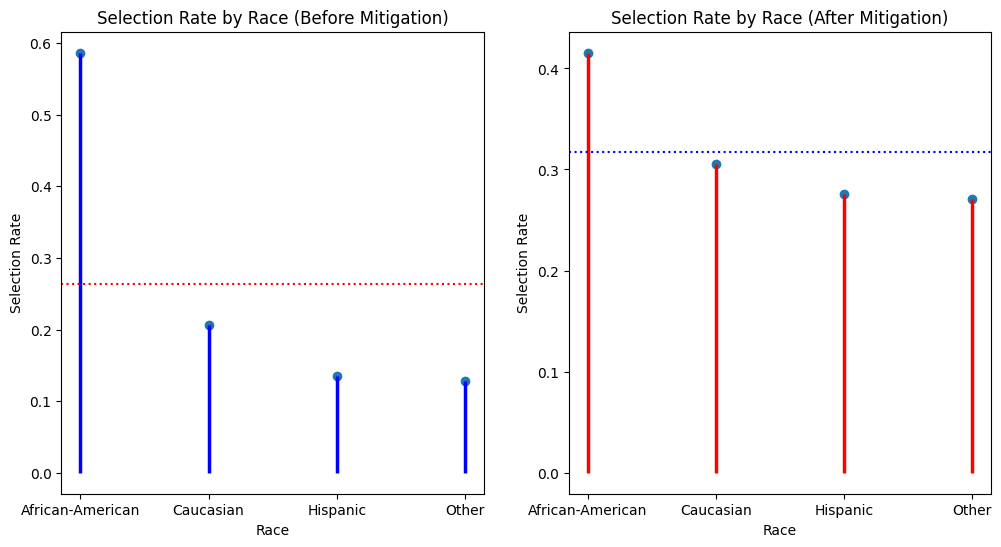

In [21]:
# Plot selection rate for each race before and after mitigation as dot plots with vertical lines for each race
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Calculate mean selection rates
mean_selection_rate_before = metric_frame.by_group['selection_rate'].mean()
mean_selection_rate_after = metric_frame_mitigated.by_group['selection_rate'].mean()

# Plot before mitigation
ax[0].plot(metric_frame.by_group.index, metric_frame.by_group['selection_rate'], 'o', label='Before Mitigation')
for i in range(len(metric_frame.by_group.index)):
    ax[0].vlines(x=metric_frame.by_group.index[i], ymin=0, ymax=metric_frame.by_group['selection_rate'][i], colors='b', linestyles='-',linewidth=2.5)
ax[0].axhline(y=mean_selection_rate_before, color='r', linestyle='dotted', label='Mean Selection Rate')
ax[0].set_title('Selection Rate by Race (Before Mitigation)')
ax[0].set_xlabel('Race')
ax[0].set_ylabel('Selection Rate')

# Plot after mitigation
ax[1].plot(metric_frame_mitigated.by_group.index, metric_frame_mitigated.by_group['selection_rate'], 'o', label='After Mitigation')
for i in range(len(metric_frame_mitigated.by_group.index)):
    ax[1].vlines(x=metric_frame_mitigated.by_group.index[i], ymin=0, ymax=metric_frame_mitigated.by_group['selection_rate'][i], colors='r', linestyles='-',linewidth=2.5)
ax[1].axhline(y=mean_selection_rate_after, color='b', linestyle='dotted', label='Mean Selection Rate')
ax[1].set_title('Selection Rate by Race (After Mitigation)')
ax[1].set_xlabel('Race')
ax[1].set_ylabel('Selection Rate')

# Save the plot to a PDF file
#plt.subplots_adjust(bottom=0.4)
pdf = matplotlib.backends.backend_pdf.PdfPages("Selection_rate_case1a.pdf")
pdf.savefig(plt.gcf())
pdf.close()

#plt.legend()
plt.show()

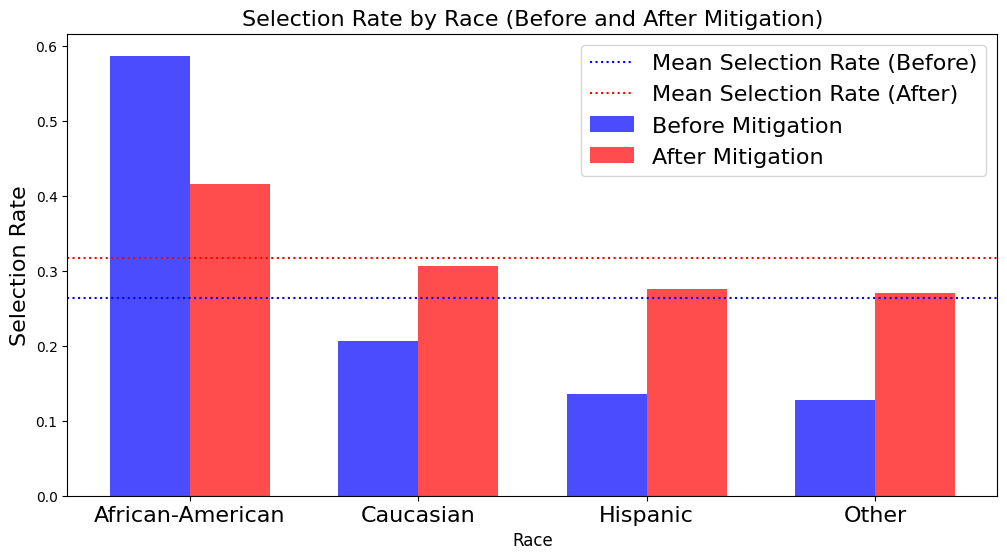

In [71]:
# Plot selection rate for each race before and after mitigation as a multiple bar chart
fig, ax = plt.subplots(figsize=(12, 6))

# Calculate mean selection rates
mean_selection_rate_before = metric_frame.by_group['selection_rate'].mean()
mean_selection_rate_after = metric_frame_mitigated.by_group['selection_rate'].mean()

# Get the races and their corresponding selection rates
races = metric_frame.by_group.index
selection_rates_before = metric_frame.by_group['selection_rate']
selection_rates_after = metric_frame_mitigated.by_group['selection_rate']

# Set the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
x = np.arange(len(races))

# Plot the bars for before and after mitigation
ax.bar(x - bar_width/2, selection_rates_before, width=bar_width, label='Before Mitigation', color='b', alpha=0.7)
ax.bar(x + bar_width/2, selection_rates_after, width=bar_width, label='After Mitigation', color='r', alpha=0.7)

# Add horizontal lines for the mean selection rates
ax.axhline(y=mean_selection_rate_before, color='b', linestyle='dotted', label='Mean Selection Rate (Before)')
ax.axhline(y=mean_selection_rate_after, color='r', linestyle='dotted', label='Mean Selection Rate (After)')

# Set the x-axis labels and title
ax.set_xticks(x)
ax.set_xticklabels(races,fontsize=16)
ax.set_xlabel('Race',fontsize=12)
ax.set_ylabel('Selection Rate',fontsize=16)
ax.set_title('Selection Rate by Race (Before and After Mitigation)',fontsize=16)

# Add a legend
ax.legend(fontsize=16)

# Save the plot to a PDF file
pdf = matplotlib.backends.backend_pdf.PdfPages("Selection_rate_case1a_bar_chart.pdf")
pdf.savefig(fig)
pdf.close()

# Show the plot
plt.show()

C:\Users\ojoak\AppData\Local\Temp\ipykernel_24368\670003954.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.vlines(x=x[i] - 0.2, ymin=0, ymax=selection_rates_before[i], color='b', linewidth=5, label='Before Mitigation' if i == 0 else "")
C:\Users\ojoak\AppData\Local\Temp\ipykernel_24368\670003954.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.vlines(x=x[i] + 0.2, ymin=0, ymax=selection_rates_after[i], color='r', linewidth=5, label='After Mitigation' if i == 0 else "")


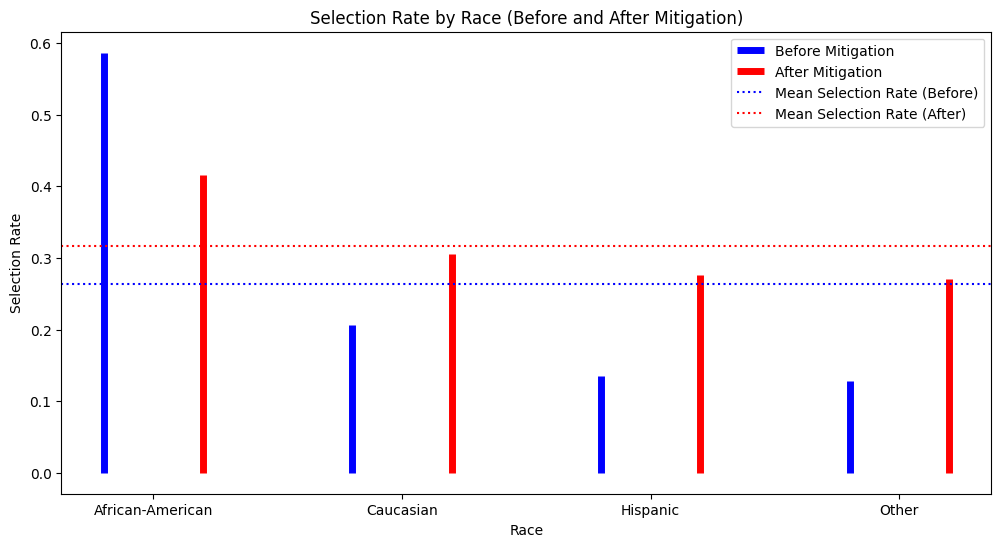

In [24]:
# Plot selection rate for each race before and after mitigation as bar lines
fig, ax = plt.subplots(figsize=(12, 6))

# Calculate mean selection rates
mean_selection_rate_before = metric_frame.by_group['selection_rate'].mean()
mean_selection_rate_after = metric_frame_mitigated.by_group['selection_rate'].mean()

# Get the races and their corresponding selection rates
races = metric_frame.by_group.index
selection_rates_before = metric_frame.by_group['selection_rate']
selection_rates_after = metric_frame_mitigated.by_group['selection_rate']

# Set the positions of the bar lines on the x-axis
x = np.arange(len(races))

# Plot vertical lines for before and after mitigation
for i in range(len(races)):
    ax.vlines(x=x[i] - 0.2, ymin=0, ymax=selection_rates_before[i], color='b', linewidth=5, label='Before Mitigation' if i == 0 else "")
    ax.vlines(x=x[i] + 0.2, ymin=0, ymax=selection_rates_after[i], color='r', linewidth=5, label='After Mitigation' if i == 0 else "")

# Add horizontal lines for the mean selection rates
ax.axhline(y=mean_selection_rate_before, color='b', linestyle='dotted', label='Mean Selection Rate (Before)')
ax.axhline(y=mean_selection_rate_after, color='r', linestyle='dotted', label='Mean Selection Rate (After)')

# Set the x-axis labels and title
ax.set_xticks(x)
ax.set_xticklabels(races)
ax.set_xlabel('Race')
ax.set_ylabel('Selection Rate')
ax.set_title('Selection Rate by Race (Before and After Mitigation)')

# Add a legend
ax.legend()

# Save the plot to a PDF file
pdf = matplotlib.backends.backend_pdf.PdfPages("Selection_rate_case1a_bar_lines.pdf")
pdf.savefig(fig)
pdf.close()

# Show the plot
plt.show()

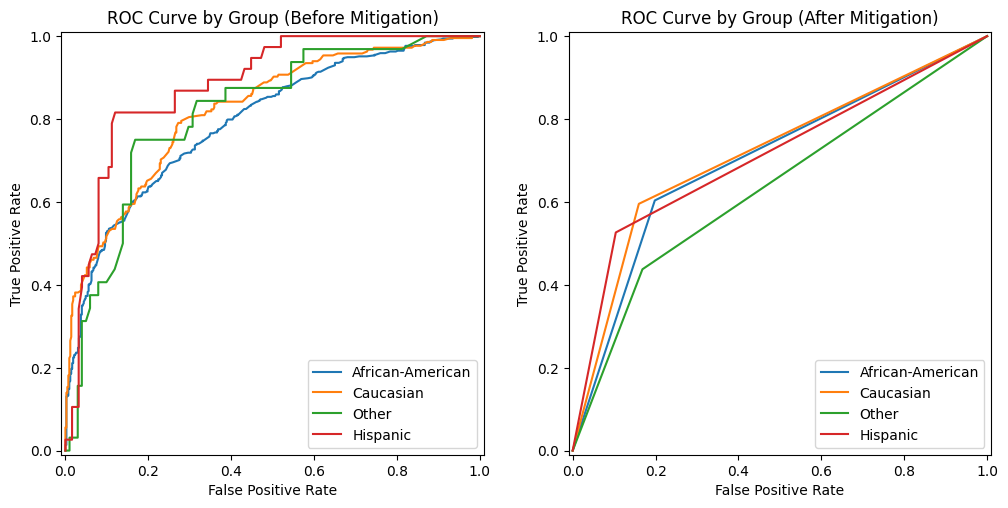

In [78]:
# Plot ROC curves for each group before and after mitigation
groups = sensitive_test.unique()
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for group in groups:
    group_mask = (sensitive_test == group)
    if group_mask.sum() > 0:  # Ensure there are samples for the group
        fpr, tpr, _ = roc_curve(y_test[group_mask], y_pred_proba[group_mask])
        RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax[0], name=f'{group}')
        fpr_mitigated, tpr_mitigated, _ = roc_curve(y_test[group_mask], y_pred_mitigated_proba[group_mask])
        RocCurveDisplay(fpr=fpr_mitigated, tpr=tpr_mitigated).plot(ax=ax[1], name=f'{group}')

ax[0].set_title('ROC Curve by Group (Before Mitigation)')
ax[1].set_title('ROC Curve by Group (After Mitigation)')

# Save the plot to a PDF file
#plt.subplots_adjust(bottom=0.4)
pdf = matplotlib.backends.backend_pdf.PdfPages("ROC_case1a.pdf")
pdf.savefig(plt.gcf())
pdf.close()

plt.show()

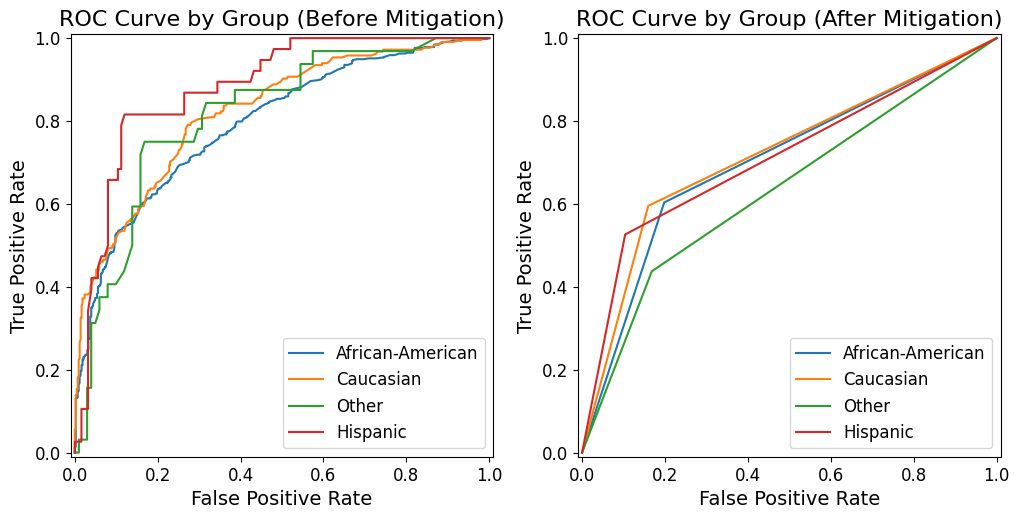

In [79]:
# Plot ROC curves for each group before and after mitigation
groups = sensitive_test.unique()
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for group in groups:
    group_mask = (sensitive_test == group)
    if group_mask.sum() > 0:  # Ensure there are samples for the group
        fpr, tpr, _ = roc_curve(y_test[group_mask], y_pred_proba[group_mask])
        RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax[0], name=f'{group}')
        fpr_mitigated, tpr_mitigated, _ = roc_curve(y_test[group_mask], y_pred_mitigated_proba[group_mask])
        RocCurveDisplay(fpr=fpr_mitigated, tpr=tpr_mitigated).plot(ax=ax[1], name=f'{group}')

# Increase font size for titles
ax[0].set_title('ROC Curve by Group (Before Mitigation)', fontsize=16)
ax[1].set_title('ROC Curve by Group (After Mitigation)', fontsize=16)

# Increase font size for x and y labels
ax[0].set_xlabel('False Positive Rate', fontsize=14)
ax[0].set_ylabel('True Positive Rate', fontsize=14)
ax[1].set_xlabel('False Positive Rate', fontsize=14)
ax[1].set_ylabel('True Positive Rate', fontsize=14)

# Increase font size for tick labels
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[1].tick_params(axis='both', which='major', labelsize=12)

# Increase font size for legend
ax[0].legend(fontsize=12)
ax[1].legend(fontsize=12)

# Save the plot to a PDF file
pdf = matplotlib.backends.backend_pdf.PdfPages("ROC_case1a.pdf")
pdf.savefig(plt.gcf())
pdf.close()

plt.show()

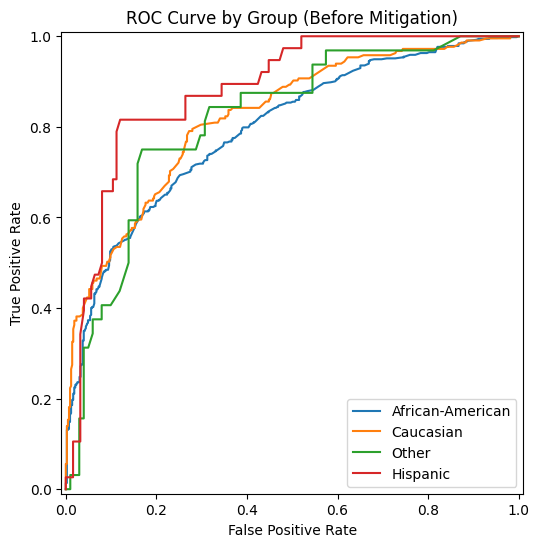

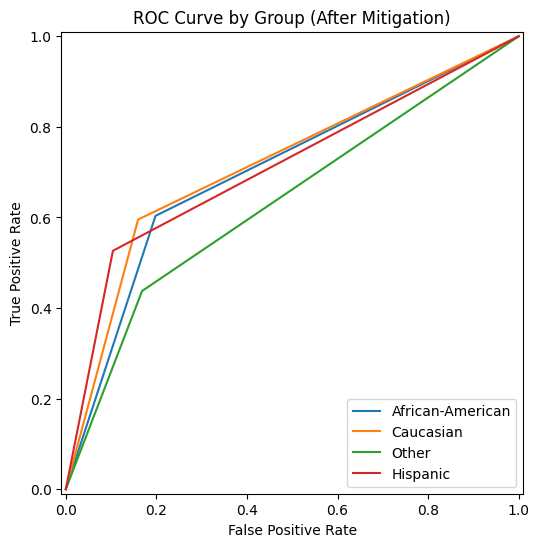

In [26]:
# Plot ROC curves for each group before mitigation
ROC_New1a, ax1 = plt.subplots(figsize=(6, 6))
for group in groups:
    group_mask = (sensitive_test == group)
    if group_mask.sum() > 0:  # Ensure there are samples for the group
        fpr, tpr, _ = roc_curve(y_test[group_mask], y_pred_proba[group_mask])
        RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax1, name=f'{group}')
ax1.set_title('ROC Curve by Group (Before Mitigation)')

# Save the first plot to a PDF file
pdf = matplotlib.backends.backend_pdf.PdfPages("ROC_before_mitigation.pdf")
pdf.savefig(ROC_New1a)
pdf.close()

# Plot ROC curves for each group after mitigation
ROC_New1b, ax2 = plt.subplots(figsize=(6, 6))
for group in groups:
    group_mask = (sensitive_test == group)
    if group_mask.sum() > 0:  # Ensure there are samples for the group
        fpr_mitigated, tpr_mitigated, _ = roc_curve(y_test[group_mask], y_pred_mitigated_proba[group_mask])
        RocCurveDisplay(fpr=fpr_mitigated, tpr=tpr_mitigated).plot(ax=ax2, name=f'{group}')
ax2.set_title('ROC Curve by Group (After Mitigation)')

# Save the second plot to a PDF file
pdf = matplotlib.backends.backend_pdf.PdfPages("ROC_after_mitigation.pdf")
pdf.savefig(ROC_New1b)
pdf.close()

plt.show()

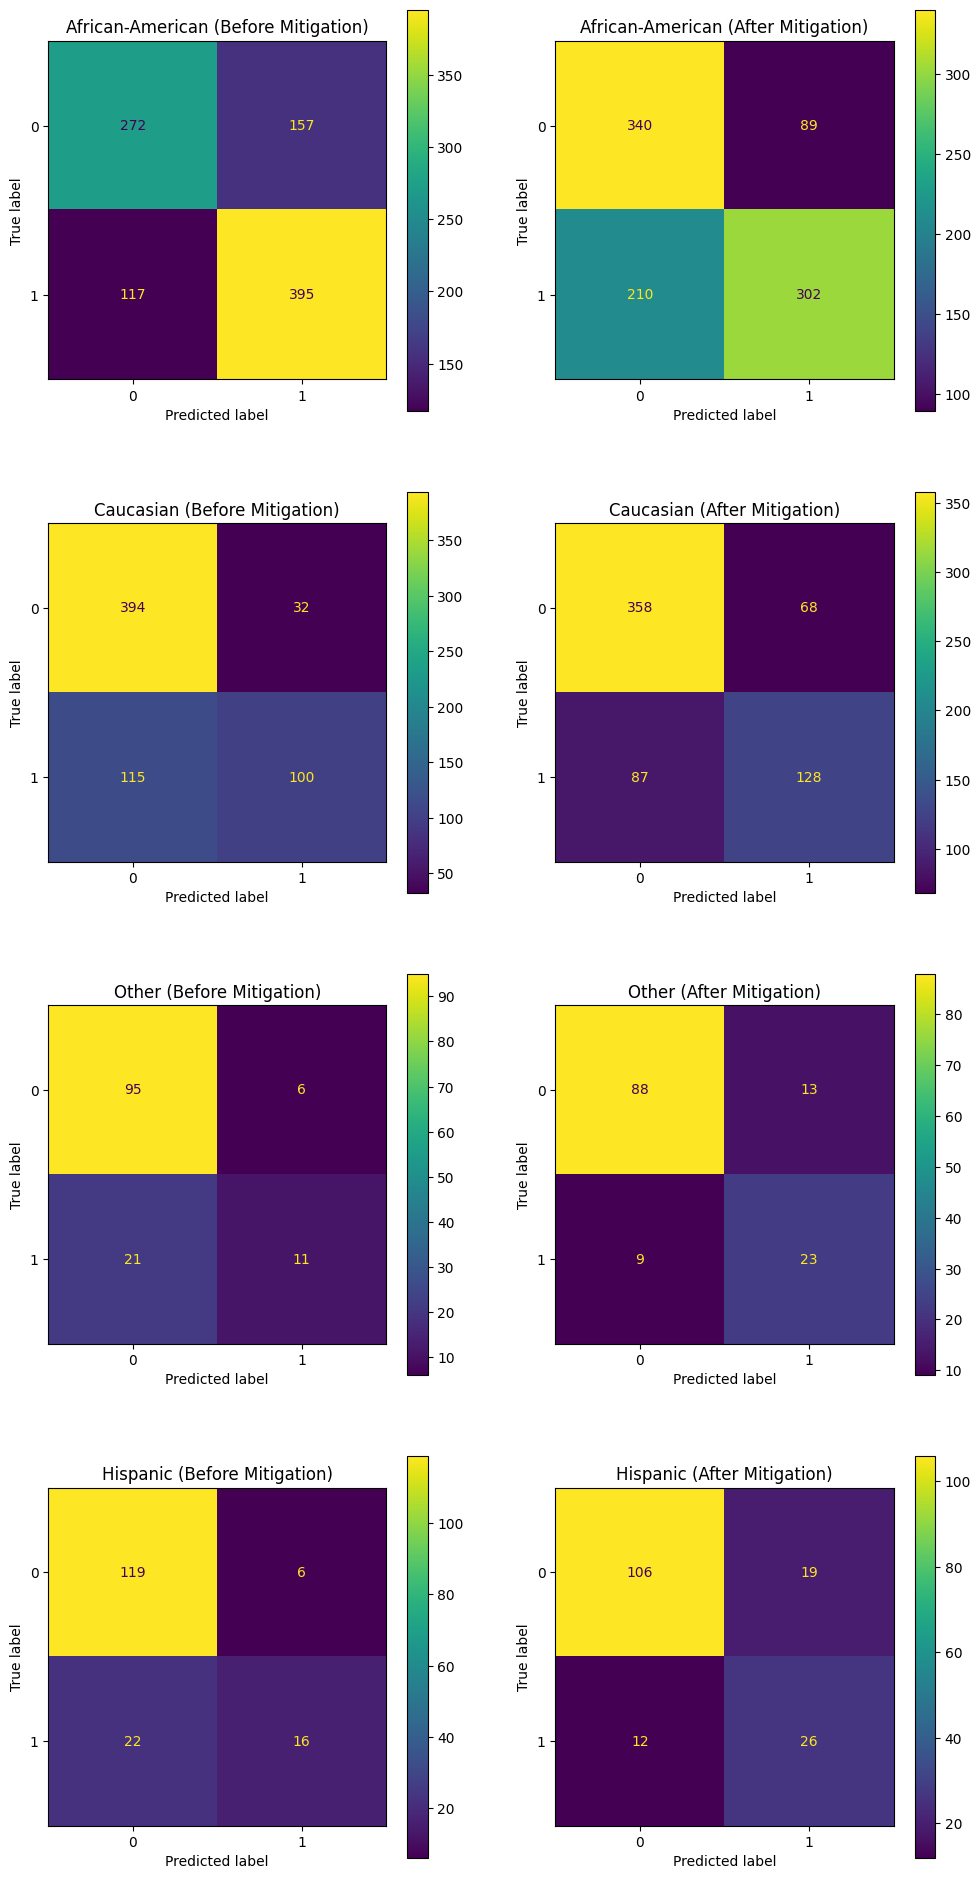

In [27]:
# Generate confusion matrices for each group before and after mitigation
fig, ax = plt.subplots(len(groups), 2, figsize=(12, 6 * len(groups)))

for i, group in enumerate(groups):
    group_mask = (sensitive_test == group)
    if group_mask.sum() > 0:  # Ensure there are samples for the group
        cm_before = confusion_matrix(y_test[group_mask], y_pred[group_mask])
        cm_display_before = ConfusionMatrixDisplay(confusion_matrix=cm_before)
        cm_display_before.plot(ax=ax[i][0])
        ax[i][0].set_title(f'{group} (Before Mitigation)')

        cm_after = confusion_matrix(y_test[group_mask], y_pred_mitigated[group_mask])
        cm_display_after = ConfusionMatrixDisplay(confusion_matrix=cm_after)
        cm_display_after.plot(ax=ax[i][1])
        ax[i][1].set_title(f'{group} (After Mitigation)')

plt.show()

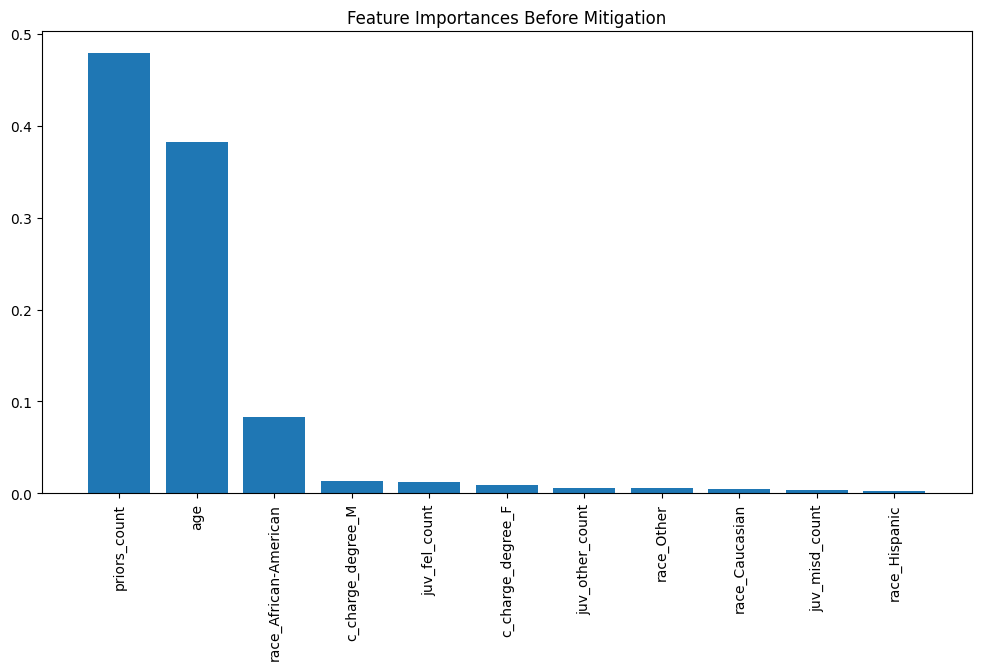

In [28]:
# Plot VIP (Variable Importance Plot) for the model before mitigation
feature_importances_before = model.feature_importances_
indices_before = np.argsort(feature_importances_before)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importances Before Mitigation")
plt.bar(range(X.shape[1]), feature_importances_before[indices_before], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices_before], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

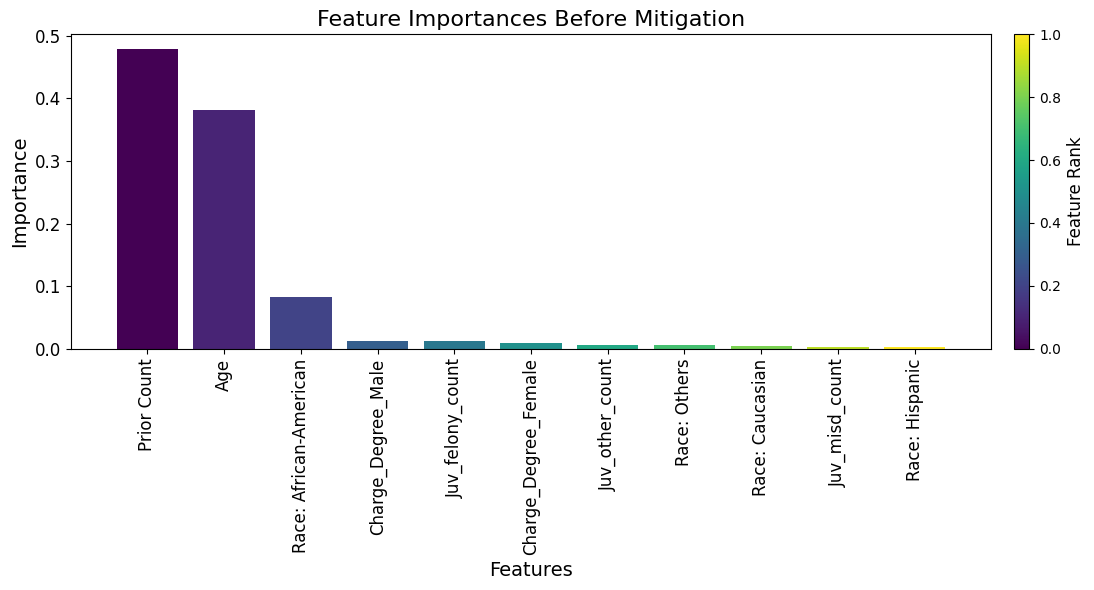

In [126]:
# Plot VIP (Variable Importance Plot) for the model before mitigation
feature_importances_before = model.feature_importances_
indices_before = np.argsort(feature_importances_before)[::-1]

# Define the mapping of new feature names to original feature names
feature_name_mapping = {
    "Prior Count": "priors_count",
    "Age": "age",
    "Race: African-American": "race_African-American",
    "Charge_Degree_Female": "c_charge_degree_F",
    "Juv_felony_count": "juv_fel_count",
    "Charge_Degree_Male": "c_charge_degree_M",
    "Juv_other_count": "juv_other_count",
    "Race: Others": "race_Other",
    "Race: Caucasian": "race_Caucasian",
    "Juv_misd_count": "juv_misd_count",
    "Race: Hispanic": "race_Hispanic"
}

# Extract the new feature names in the correct order based on feature importance
new_feature_names = [list(feature_name_mapping.keys())[list(feature_name_mapping.values()).index(X.columns[i])] for i in indices_before]

# Create a colormap for the bars
colors = plt.cm.viridis(np.linspace(0, 1, len(indices_before)))  # Use a colormap (e.g., viridis)

# Plot
plt.figure(figsize=(12, 6))
plt.title("Feature Importances Before Mitigation", fontsize=16)
bars = plt.bar(range(X.shape[1]), feature_importances_before[indices_before], align="center", color=colors)

# Customize x-axis labels with the new feature names
plt.xticks(range(X.shape[1]), new_feature_names, rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Features", fontsize=14)
plt.ylabel("Importance", fontsize=14)
plt.xlim([-1, X.shape[1]])

# Add a color bar for reference (optional)
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical', pad=0.02)
cbar.set_label('Feature Rank', fontsize=12)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

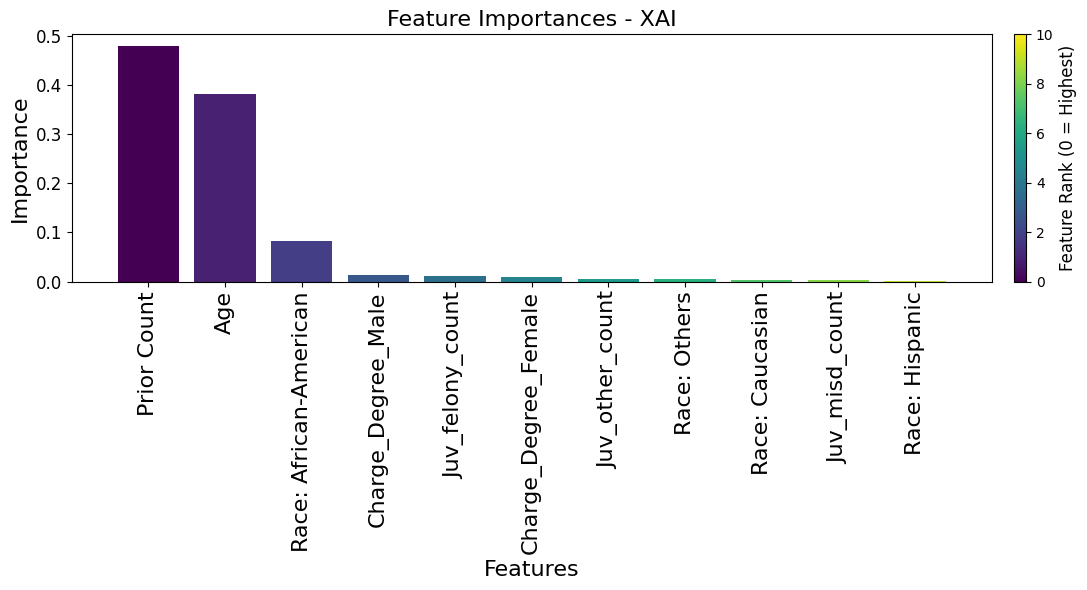

In [130]:
# Plot VIP (Variable Importance Plot) for the model before mitigation
feature_importances_before = model.feature_importances_
indices_before = np.argsort(feature_importances_before)[::-1]  # Sort in descending order

# Define the mapping of new feature names to original feature names
feature_name_mapping = {
    "Prior Count": "priors_count",
    "Age": "age",
    "Race: African-American": "race_African-American",
    "Charge_Degree_Female": "c_charge_degree_F",
    "Juv_felony_count": "juv_fel_count",
    "Charge_Degree_Male": "c_charge_degree_M",
    "Juv_other_count": "juv_other_count",
    "Race: Others": "race_Other",
    "Race: Caucasian": "race_Caucasian",
    "Juv_misd_count": "juv_misd_count",
    "Race: Hispanic": "race_Hispanic"
}

# Extract the new feature names in the correct order based on feature importance
new_feature_names = [list(feature_name_mapping.keys())[list(feature_name_mapping.values()).index(X.columns[i])] for i in indices_before]

# Create a colormap for the bars based on feature rank
feature_ranks = np.arange(len(indices_before))  # Rank features from 0 (highest) to N-1 (lowest)
colors = plt.cm.viridis(feature_ranks / len(indices_before))  # Normalize ranks to [0, 1] for colormap

# Plot
plt.figure(figsize=(12, 6))
plt.title("Feature Importances - XAI", fontsize=16)
bars = plt.bar(range(X.shape[1]), feature_importances_before[indices_before], align="center", color=colors)

# Customize x-axis labels with the new feature names
plt.xticks(range(X.shape[1]), new_feature_names, rotation=90, fontsize=16)
plt.yticks(fontsize=12)
plt.xlabel("Features", fontsize=16)
plt.ylabel("Importance", fontsize=16)
plt.xlim([-1, X.shape[1]])

# Add a color bar for reference (optional)
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=0, vmax=len(indices_before) - 1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical', pad=0.02)
cbar.set_label('Feature Rank (0 = Highest)', fontsize=12)

plt.tight_layout()  # Adjust layout to prevent overlap

# Adjust layout to prevent cutting off
plt.tight_layout()

# Save the plot to a PDF file
pdf = matplotlib.backends.backend_pdf.PdfPages("XAI_case1a.pdf")
pdf.savefig(plt.gcf())
pdf.close()

plt.show()

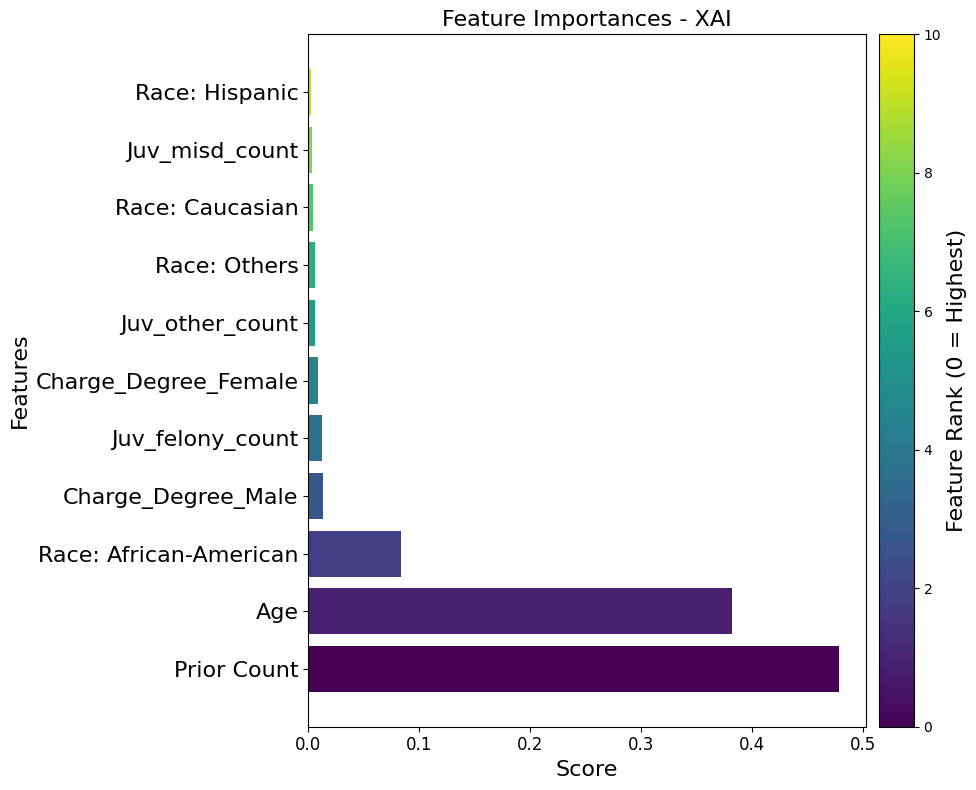

In [138]:
# Plot VIP (Variable Importance Plot) for the model before mitigation
feature_importances_before = model.feature_importances_
indices_before = np.argsort(feature_importances_before)[::-1]  # Sort in descending order

# Define the mapping of new feature names to original feature names
feature_name_mapping = {
    "Prior Count": "priors_count",
    "Age": "age",
    "Race: African-American": "race_African-American",
    "Charge_Degree_Female": "c_charge_degree_F",
    "Juv_felony_count": "juv_fel_count",
    "Charge_Degree_Male": "c_charge_degree_M",
    "Juv_other_count": "juv_other_count",
    "Race: Others": "race_Other",
    "Race: Caucasian": "race_Caucasian",
    "Juv_misd_count": "juv_misd_count",
    "Race: Hispanic": "race_Hispanic"
}

# Extract the new feature names in the correct order based on feature importance
new_feature_names = [list(feature_name_mapping.keys())[list(feature_name_mapping.values()).index(X.columns[i])] for i in indices_before]

# Create a colormap for the bars based on feature rank
feature_ranks = np.arange(len(indices_before))  # Rank features from 0 (highest) to N-1 (lowest)
colors = plt.cm.viridis(feature_ranks / len(indices_before))  # Normalize ranks to [0, 1] for colormap

# Plot horizontal bars
plt.figure(figsize=(10, 8))  # Adjust figure size for better readability
plt.title("Feature Importances - XAI", fontsize=16)
bars = plt.barh(range(X.shape[1]), feature_importances_before[indices_before], align="center", color=colors)

# Customize y-axis labels with the new feature names
plt.yticks(range(X.shape[1]), new_feature_names, fontsize=16)
plt.xticks(fontsize=12)
plt.xlabel("Score", fontsize=16)
plt.ylabel("Features", fontsize=16)
plt.ylim([-1, X.shape[1]])

# Add a color bar for reference (optional)
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=0, vmax=len(indices_before) - 1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical', pad=0.02)
cbar.set_label('Feature Rank (0 = Highest)', fontsize=16)

# Adjust layout to prevent cutting off
plt.tight_layout()

# Save the plot to a PDF file
pdf = matplotlib.backends.backend_pdf.PdfPages("XAI_case1aH.pdf")
pdf.savefig(plt.gcf())
pdf.close()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

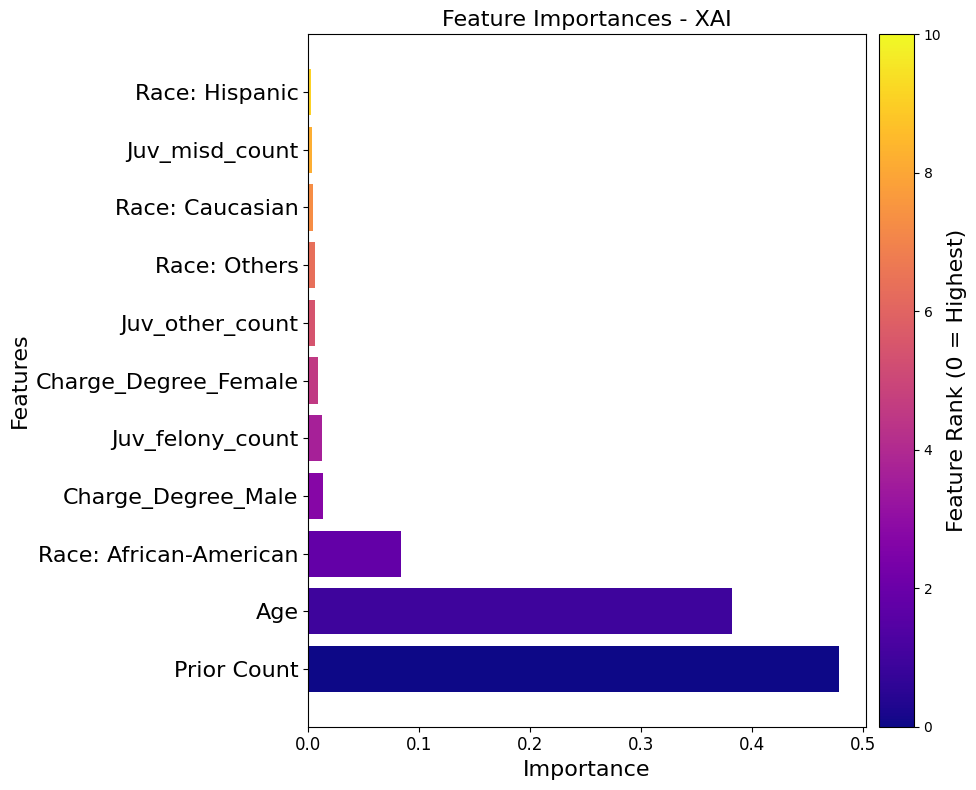

In [144]:
import numpy as np
import matplotlib.pyplot as plt

# Plot VIP (Variable Importance Plot) for the model before mitigation
feature_importances_before = model.feature_importances_
indices_before = np.argsort(feature_importances_before)[::-1]  # Sort in descending order

# Define the mapping of new feature names to original feature names
feature_name_mapping = {
    "Prior Count": "priors_count",
    "Age": "age",
    "Race: African-American": "race_African-American",
    "Charge_Degree_Female": "c_charge_degree_F",
    "Juv_felony_count": "juv_fel_count",
    "Charge_Degree_Male": "c_charge_degree_M",
    "Juv_other_count": "juv_other_count",
    "Race: Others": "race_Other",
    "Race: Caucasian": "race_Caucasian",
    "Juv_misd_count": "juv_misd_count",
    "Race: Hispanic": "race_Hispanic"
}

# Extract the new feature names in the correct order based on feature importance
new_feature_names = [list(feature_name_mapping.keys())[list(feature_name_mapping.values()).index(X.columns[i])] for i in indices_before]

# Create a colormap for the bars based on feature rank (using a bright colormap)
feature_ranks = np.arange(len(indices_before))  # Rank features from 0 (highest) to N-1 (lowest)
colors = plt.cm.plasma(feature_ranks / len(indices_before))  # Use a bright colormap (e.g., plasma)

# Plot horizontal bars
plt.figure(figsize=(10, 8))  # Adjust figure size for better readability
plt.title("Feature Importances - XAI", fontsize=16)
bars = plt.barh(range(X.shape[1]), feature_importances_before[indices_before], align="center", color=colors)

# Customize y-axis labels with the new feature names
plt.yticks(range(X.shape[1]), new_feature_names, fontsize=16)
plt.xticks(fontsize=12)
plt.xlabel("Importance", fontsize=16)
plt.ylabel("Features", fontsize=16)
plt.ylim([-1, X.shape[1]])

# Add a color bar for reference (optional)
sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(vmin=0, vmax=len(indices_before) - 1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical', pad=0.02)
cbar.set_label('Feature Rank (0 = Highest)', fontsize=16)


# Adjust layout to prevent cutting off
plt.tight_layout()

# Save the plot to a PDF file
pdf = matplotlib.backends.backend_pdf.PdfPages("XAI_case1aB.pdf")
pdf.savefig(plt.gcf())
pdf.close()


plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

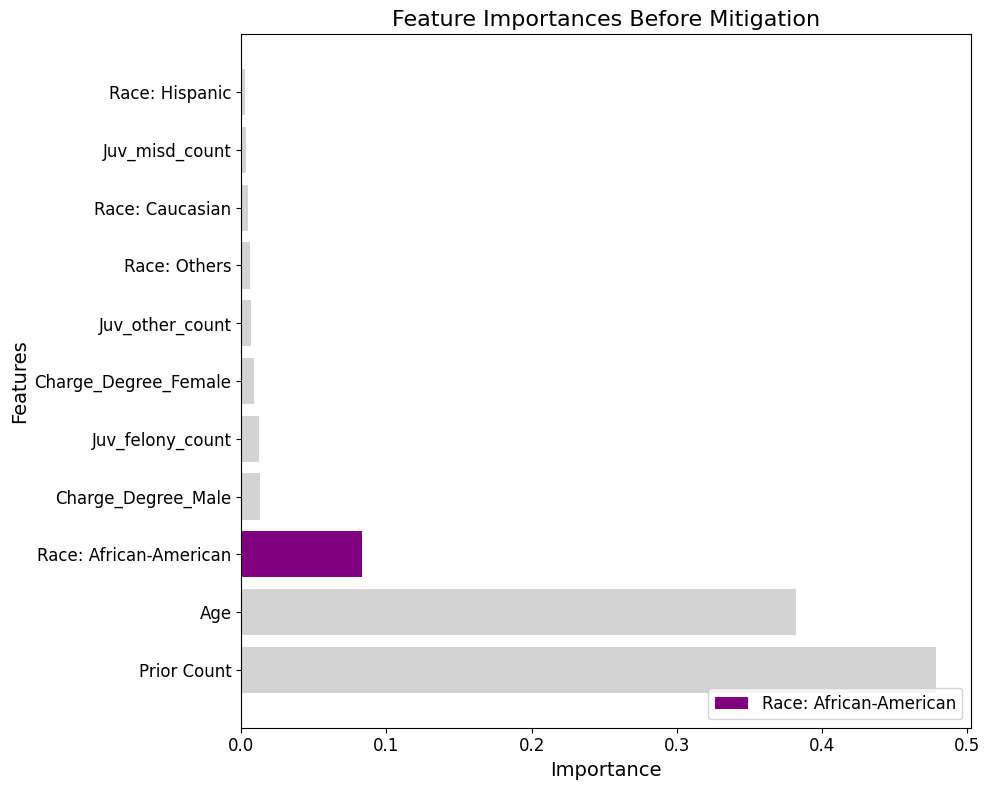

In [140]:
# Plot VIP (Variable Importance Plot) for the model before mitigation
feature_importances_before = model.feature_importances_
indices_before = np.argsort(feature_importances_before)[::-1]  # Sort in descending order

# Define the mapping of new feature names to original feature names
feature_name_mapping = {
    "Prior Count": "priors_count",
    "Age": "age",
    "Race: African-American": "race_African-American",
    "Charge_Degree_Female": "c_charge_degree_F",
    "Juv_felony_count": "juv_fel_count",
    "Charge_Degree_Male": "c_charge_degree_M",
    "Juv_other_count": "juv_other_count",
    "Race: Others": "race_Other",
    "Race: Caucasian": "race_Caucasian",
    "Juv_misd_count": "juv_misd_count",
    "Race: Hispanic": "race_Hispanic"
}

# Extract the new feature names in the correct order based on feature importance
new_feature_names = [list(feature_name_mapping.keys())[list(feature_name_mapping.values()).index(X.columns[i])] for i in indices_before]

# Create a list of colors, highlighting "Race: African-American" with purple
colors = []
for feature_name in new_feature_names:
    if feature_name == "Race: African-American":
        colors.append('purple')  # Highlight this feature with purple
    else:
        colors.append('lightgray')  # Use a neutral color for other features

# Plot horizontal bars
plt.figure(figsize=(10, 8))  # Adjust figure size for better readability
plt.title("Feature Importances Before Mitigation", fontsize=16)
bars = plt.barh(range(X.shape[1]), feature_importances_before[indices_before], align="center", color=colors)

# Customize y-axis labels with the new feature names
plt.yticks(range(X.shape[1]), new_feature_names, fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.ylim([-1, X.shape[1]])

# Add a legend to explain the highlighted bar
plt.legend([bars[new_feature_names.index("Race: African-American")]], ["Race: African-American"], fontsize=12, loc='lower right')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

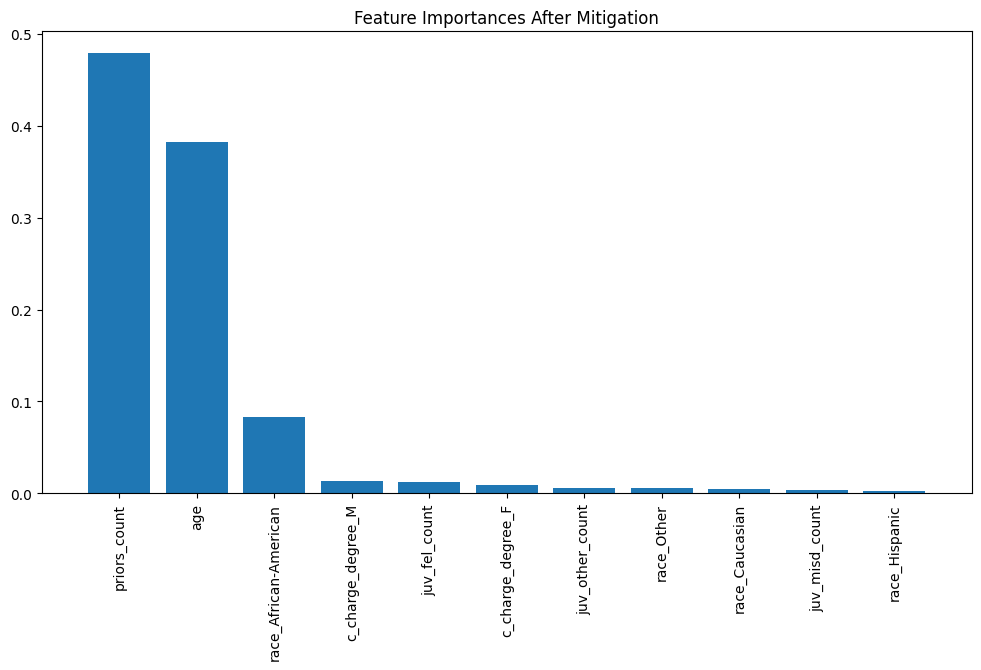

In [29]:
# Plot VIP (Variable Importance Plot) for the model after mitigation
feature_importances_after = threshold_optimizer.estimator_.feature_importances_
indices_after = np.argsort(feature_importances_after)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importances After Mitigation")
plt.bar(range(X.shape[1]), feature_importances_after[indices_after], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices_after], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

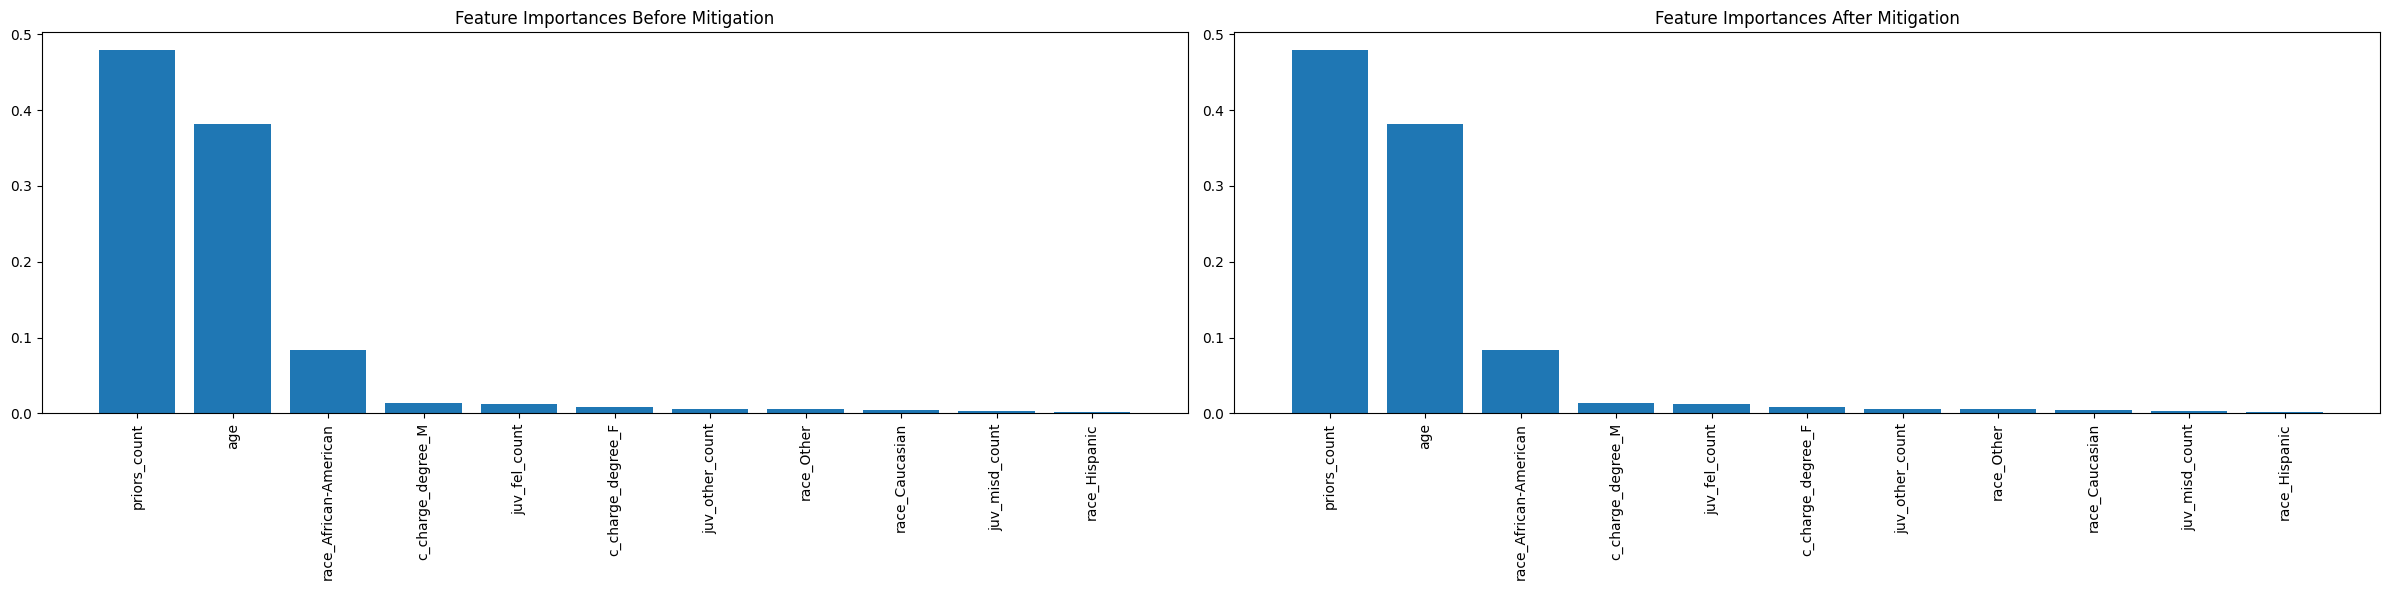

In [30]:
# side-by-side plot
feature_importances_before = model.feature_importances_
indices_before = np.argsort(feature_importances_before)[::-1]

feature_importances_after = threshold_optimizer.estimator_.feature_importances_
indices_after = np.argsort(feature_importances_after)[::-1]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))

# Plot for the model before mitigation
axes[0].bar(range(X.shape[1]), feature_importances_before[indices_before], align="center")
axes[0].set_title("Feature Importances Before Mitigation")
axes[0].set_xticks(range(X.shape[1]))
axes[0].set_xticklabels(X.columns[indices_before], rotation=90)
axes[0].set_xlim([-1, X.shape[1]])

# Plot for the model after mitigation
axes[1].bar(range(X.shape[1]), feature_importances_after[indices_after], align="center")
axes[1].set_title("Feature Importances After Mitigation")
axes[1].set_xticks(range(X.shape[1]))
axes[1].set_xticklabels(X.columns[indices_after], rotation=90)
axes[1].set_xlim([-1, X.shape[1]])

plt.tight_layout()  # Adjust subplots to fit into figure area.
# Save the plot to a PDF file
#plt.subplots_adjust(bottom=0.4)
pdf = matplotlib.backends.backend_pdf.PdfPages("VIPb_case2a.pdf")
pdf.savefig(plt.gcf())
pdf.close()

plt.show()

In [31]:
# Make predictions before mitigation
y_pred_before = model.predict(X_test)
y_pred_proba_before = model.predict_proba(X_test)[:, 1]

In [ ]:
#... 

In [33]:
# Mitigate bias using ThresholdOptimizer with Equalized Odds
threshold_optimizer = ThresholdOptimizer(estimator=model, constraints="equalized_odds", prefit=True)
threshold_optimizer.fit(X_test, y_test, sensitive_features=sensitive_test)
y_pred_after = threshold_optimizer.predict(X_test, sensitive_features=sensitive_test)
y_pred_proba_after = threshold_optimizer.predict(X_test, sensitive_features=sensitive_test)

In [34]:
# Calculate classifier probability scores for false positives and false negatives for each sample for all races before and after mitigation
false_positives_before = (y_test == 0) & (y_pred_before == 1)
false_negatives_before = (y_test == 1) & (y_pred_before == 0)

false_positives_after = (y_test == 0) & (y_pred_after == 1)
false_negatives_after = (y_test == 1) & (y_pred_after == 0)

In [35]:
# Create a DataFrame to store the results before and after mitigation
results_df_before = pd.DataFrame({
    'Race': sensitive_test,
    'True Label': y_test,
    'Predicted Label': y_pred_before,
    'Probability Score': y_pred_proba_before,
    'False Positive': false_positives_before,
    'False Negative': false_negatives_before,
    'False Positive Score': np.where(false_positives_before, y_pred_proba_before, np.nan),
    'False Negative Score': np.where(false_negatives_before, y_pred_proba_before, np.nan),
    'Mitigation': 'Before'
})

In [36]:
results_df_after = pd.DataFrame({
    'Race': sensitive_test,
    'True Label': y_test,
    'Predicted Label': y_pred_after,
    'Probability Score': y_pred_proba_after,
    'False Positive': false_positives_after,
    'False Negative': false_negatives_after,
    'False Positive Score': np.where(false_positives_after, y_pred_proba_after, np.nan),
    'False Negative Score': np.where(false_negatives_after, y_pred_proba_after, np.nan),
    'Mitigation': 'After'
})

In [37]:
# Concatenate the results DataFrames
results_df = pd.concat([results_df_before, results_df_after])

In [38]:
results_df.head()

,Race,True Label,Predicted Label,Probability Score,False Positive,False Negative,False Positive Score,False Negative Score,Mitigation
2854,African-American,0,0,0.353772,False,False,NaN,NaN,Before
4762,Caucasian,0,1,0.525158,True,False,0.525158,NaN,Before
3820,African-American,0,0,0.332158,False,False,NaN,NaN,Before
8714,African-American,1,1,0.597589,False,False,NaN,NaN,Before
8551,African-American,1,1,0.976818,False,False,NaN,NaN,Before


In [37]:
# Save the results to a CSV file
results_df.to_csv('classifier_probability_scores_mitigationbiasedNEW.csv', index=False)

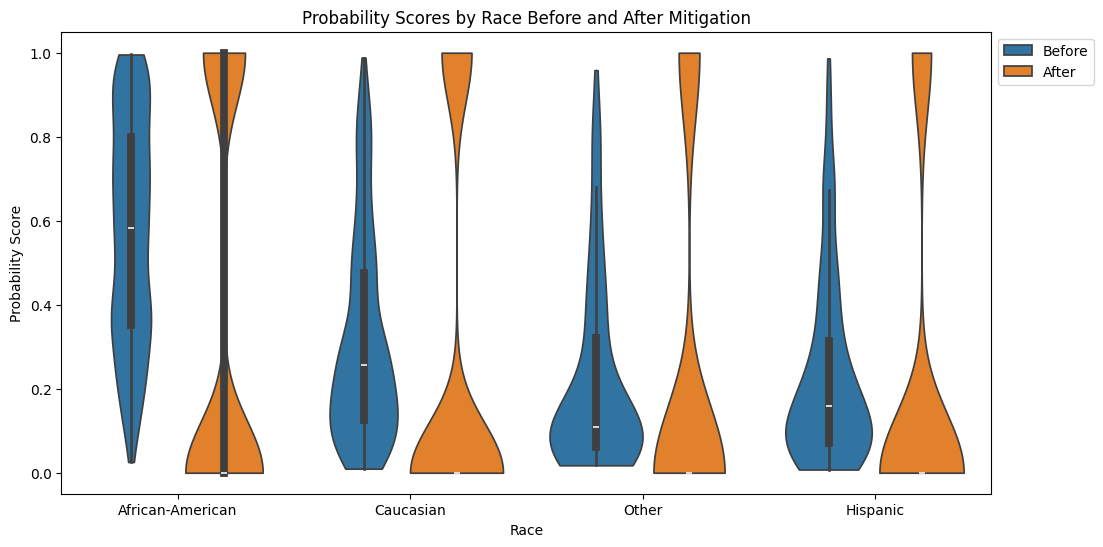

In [39]:
import seaborn as sns

# Plot a violin plot for probability scores by race before and after mitigation
plt.figure(figsize=(12, 6))
sns.violinplot(x='Race', y='Probability Score', hue='Mitigation', data=results_df, inner='box', cut=0)
plt.title('Probability Scores by Race Before and After Mitigation')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Save the plot to a PDF file
#plt.subplots_adjust(bottom=0.4)
pdf = matplotlib.backends.backend_pdf.PdfPages("ProbScore_case1a.pdf")
pdf.savefig(plt.gcf())
pdf.close()
plt.show()

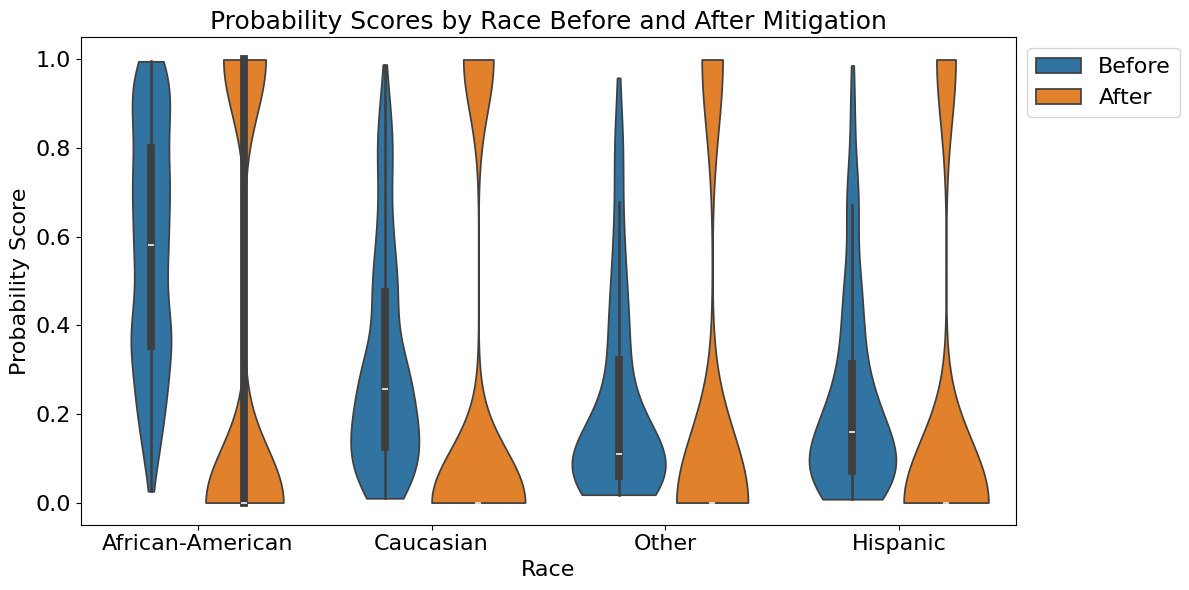

In [121]:
# Plot a violin plot for probability scores by race before and after mitigation
plt.figure(figsize=(12, 6))

# Create the violin plot
sns.violinplot(x='Race', y='Probability Score', hue='Mitigation', data=results_df, inner='box', cut=0)

# Increase font size for the title
plt.title('Probability Scores by Race Before and After Mitigation', fontsize=18)

# Increase font size for x and y labels
plt.xlabel('Race', fontsize=16)
plt.ylabel('Probability Score', fontsize=16)

# Increase font size for tick labels
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Increase font size for the legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=16)

# Adjust layout to prevent cutting off
plt.tight_layout()

# Save the plot to a PDF file
pdf = matplotlib.backends.backend_pdf.PdfPages("ProbScore_case1aF.pdf")
pdf.savefig(plt.gcf())
pdf.close()

plt.show()

C:\Users\ojoak\AppData\Local\Temp\ipykernel_24368\882802848.py:12: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.violinplot(x='Race', y='Probability Score', hue='Mitigation', data=results_df, inner='box', cut=0, palette=bright_palette)


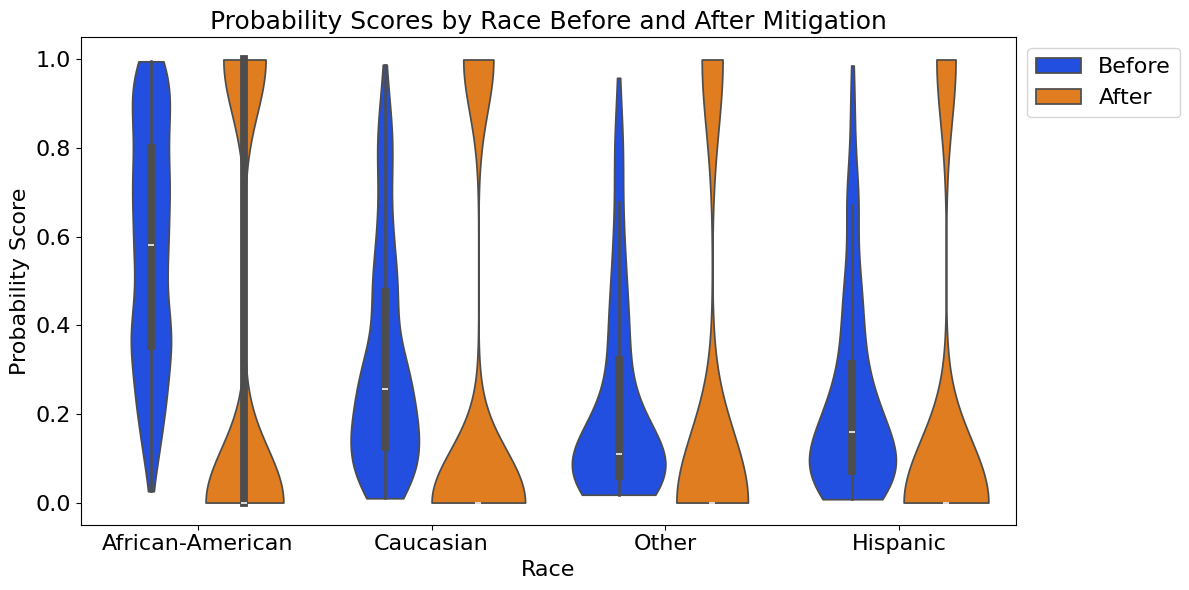

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.backends.backend_pdf

# Plot a violin plot for probability scores by race before and after mitigation
plt.figure(figsize=(12, 6))

# Use a bright color palette
bright_palette = sns.color_palette("bright")

# Create the violin plot with the bright color palette
sns.violinplot(x='Race', y='Probability Score', hue='Mitigation', data=results_df, inner='box', cut=0, palette=bright_palette)

# Increase font size for the title
plt.title('Probability Scores by Race Before and After Mitigation', fontsize=18)

# Increase font size for x and y labels
plt.xlabel('Race', fontsize=16)
plt.ylabel('Probability Score', fontsize=16)

# Increase font size for tick labels
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Increase font size for the legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=16)

# Adjust layout to prevent cutting off
plt.tight_layout()

# Save the plot to a PDF file
pdf = matplotlib.backends.backend_pdf.PdfPages("ProbScore_case1aFb.pdf")
pdf.savefig(plt.gcf())
pdf.close()

plt.show()

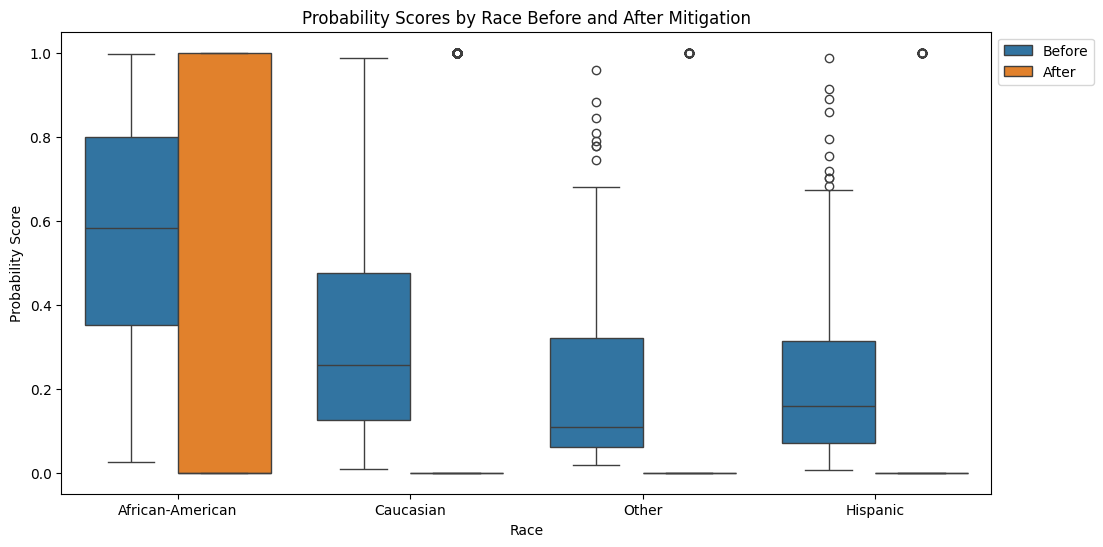

In [40]:
# Plot a boxplot for probability scores by race before and after mitigation
plt.figure(figsize=(12, 6))
sns.boxplot(x='Race', y='Probability Score', hue='Mitigation', data=results_df)
plt.title('Probability Scores by Race Before and After Mitigation')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
##################################################################################################################################################

In [587]:
#                           FAIRNESS METRICS CALCULATIONS

In [41]:
def calculate_independence_per_group(metrics_df):
  """
  Calculates independence Odds Difference for each group in the DataFrame.

  Args:
    metrics_df: pandas DataFrame with columns: 'Race', 'TPR', 'FPR' 

  Returns:
    pandas DataFrame with independence Odds Difference for each group.
  """

  groups = metrics_df_before['Race'].unique()
  results = []

  for group in groups:
    group_data = metrics_df_before[metrics_df['Race'] == group] 
    group_select = group_data['Selection'].values[0]
    #group_fpr = group_data['FPR'].values[0]

    independence_odds_diffs = []
    for other_group in groups:
      if group == other_group:
        continue  # Don't compare self

      other_group_data = metrics_df[metrics_df['Race'] == other_group]
      other_group_select = other_group_data['Selection'].values[0]
      #other_group_fpr = other_group_data['FPR'].values[0]

      diff = abs(group_select - other_group_select) #+ abs(group_fpr - other_group_fpr)
      independence_odds_diffs.append(diff)

    results.append({'Race': group, 'independence Odds Diff': max(independence_odds_diffs)})

  return pd.DataFrame(results)

# Sample DataFrame
metrics_df_before = pd.DataFrame({
    'Race': ['African-American', 'Caucasian', 'Hispanic','Other'],
    'Selection': [0.5866,0.2029,0.1350,0.1278]
})

independence_odds_per_group = calculate_independence_per_group(metrics_df_before)
print("independence Odds Difference per Group:")
print(independence_odds_per_group)

independence Odds Difference per Group:
               Race  independence Odds Diff
0  African-American                  0.4588
1         Caucasian                  0.3837
2          Hispanic                  0.4516
3             Other                  0.4588


In [42]:
def calculate_equalized_odds_per_group(metrics_df):
  """
  Calculates Equalized Odds Difference for each group in the DataFrame.

  Args:
    metrics_df: pandas DataFrame with columns: 'Race', 'TPR', 'FPR' 

  Returns:
    pandas DataFrame with Equalized Odds Difference for each group.
  """

  groups = metrics_df_before['Race'].unique()
  results = []

  for group in groups:
    group_data = metrics_df_before[metrics_df['Race'] == group] 
    group_tpr = group_data['TPR'].values[0]
    group_fpr = group_data['FPR'].values[0]

    equalized_odds_diffs = []
    for other_group in groups:
      if group == other_group:
        continue  # Don't compare self

      other_group_data = metrics_df[metrics_df['Race'] == other_group]
      other_group_tpr = other_group_data['TPR'].values[0]
      other_group_fpr = other_group_data['FPR'].values[0]

      diff = abs(group_tpr - other_group_tpr) + abs(group_fpr - other_group_fpr)
      equalized_odds_diffs.append(diff)

    results.append({'Race': group, 'Equalized Odds Diff': max(equalized_odds_diffs)})

  return pd.DataFrame(results)

# Sample DataFrame
metrics_df_before = pd.DataFrame({
    'Race': ['African-American', 'Caucasian', 'Hispanic','Other'],
    'TPR': [0.7715,0.4651,0.4211,0.3438],
    'FPR': [0.3660,0.0751,0.0480,0.0594]
})

equalized_odds_per_group = calculate_equalized_odds_per_group(metrics_df_before)
print("Equalized Odds Difference per Group:")
print(equalized_odds_per_group)

Equalized Odds Difference per Group:
               Race  Equalized Odds Diff
0  African-American               0.7343
1         Caucasian               0.5973
2          Hispanic               0.6684
3             Other               0.7343


In [43]:
def calculate_sufficiency_per_group(metrics_df):
  """
  Calculates Sufficiency Difference for each group in the DataFrame.

  Args:
    metrics_df: pandas DataFrame with columns: 'Race', 'PPV', 'NPV' 

  Returns:
    pandas DataFrame with Sufficiency Difference for each group.
  """

  groups = metrics_df['Race'].unique()
  results = []

  for group in groups:
    group_data = metrics_df[metrics_df['Race'] == group] 
    group_ppv = group_data['PPV'].values[0]
    group_npv = group_data['NPV'].values[0]

    sufficiency_diffs = []
    for other_group in groups:
      if group == other_group:
        continue  # Skip comparison with itself

      other_group_data = metrics_df[metrics_df['Race'] == other_group]
      other_group_ppv = other_group_data['PPV'].values[0]
      other_group_npv = other_group_data['NPV'].values[0]

      diff = abs(group_ppv - other_group_ppv) + abs(group_npv - other_group_npv)
      sufficiency_diffs.append(diff)

    results.append({'Race': group, 'Sufficiency Diff': max(sufficiency_diffs)})

  return pd.DataFrame(results)

# Sample DataFrame (assuming you have PPV and NPV columns)
metrics_df_before = pd.DataFrame({
    'Race': ['African-American', 'Caucasian', 'Hispanic','Other'],
    'PPV': [0.7156,0.7576,0.7273,0.6471],
    'NPV': [0.6992,0.7741,0.8440,0.8190] 
})

sufficiency_per_group = calculate_sufficiency_per_group(metrics_df_before)
print("Sufficiency Difference per Group:")
print(sufficiency_per_group)

Sufficiency Difference per Group:
               Race  Sufficiency Diff
0  African-American            0.1883
1         Caucasian            0.1554
2          Hispanic            0.1565
3             Other            0.1883


In [44]:
def calculate_independence_after_per_group(metrics_df):
  """
  Calculates independence Difference for each group in the DataFrame.

  Args:
    metrics_df: pandas DataFrame with columns: 'Race', 'TPR', 'FPR' 

  Returns:
    pandas DataFrame with independence Difference for each group.
  """

  groups = metrics_df_after['Race'].unique()
  results = []

  for group in groups:
    group_data = metrics_df_after[metrics_df['Race'] == group] 
    group_select = group_data['Selection'].values[0]
    #group_fpr = group_data['FPR'].values[0]

    independence_diffs = []
    for other_group in groups:
      if group == other_group:
        continue  # Don't compare self

      other_group_data = metrics_df[metrics_df['Race'] == other_group]
      other_group_select = other_group_data['Selection'].values[0]
      #other_group_fpr = other_group_data['FPR'].values[0]

      diff = abs(group_select - other_group_select) #+ abs(group_fpr - other_group_fpr)
      independence_diffs.append(diff)

    results.append({'Race': group, 'independence Diff': max(independence_diffs)})

  return pd.DataFrame(results)

# Sample DataFrame
metrics_df_after = pd.DataFrame({
    'Race': ['African-American', 'Caucasian', 'Hispanic','Other'],
    'Selection': [0.4123,0.3058,0.2270,0.2481]
})

independence_after_per_group = calculate_independence_after_per_group(metrics_df_after)
print("independence Difference per Group:")
print(independence_after_per_group)

independence Difference per Group:
               Race  independence Diff
0  African-American             0.1853
1         Caucasian             0.1065
2          Hispanic             0.1853
3             Other             0.1642


In [45]:
def calculate_equalized_odds_per_group(metrics_df):
  """
  Calculates Equalized Odds Difference for each group in the DataFrame.

  Args:
    metrics_df: pandas DataFrame with columns: 'Race', 'TPR', 'FPR' 

  Returns:
    pandas DataFrame with Equalized Odds Difference for each group.
  """

  groups = metrics_df_after['Race'].unique()
  results = []

  for group in groups:
    group_data = metrics_df_after[metrics_df_after['Race'] == group] 
    group_tpr = group_data['TPR'].values[0]
    group_fpr = group_data['FPR'].values[0]

    equalized_odds_diffs = []
    for other_group in groups:
      if group == other_group:
        continue  # Don't compare self

      other_group_data = metrics_df_after[metrics_df_after['Race'] == other_group]
      other_group_tpr = other_group_data['TPR'].values[0]
      other_group_fpr = other_group_data['FPR'].values[0]

      diff = abs(group_tpr - other_group_tpr) + abs(group_fpr - other_group_fpr)
      equalized_odds_diffs.append(diff)

    results.append({'Race': group, 'Equalized Odds Diff': max(equalized_odds_diffs)})

  return pd.DataFrame(results)

# Sample DataFrame
metrics_df_after = pd.DataFrame({
    'Race': ['African-American', 'Caucasian', 'Hispanic','Other'],
    'TPR': [0.5840,0.5953,0.6579,0.5313],
    'FPR': [0.2075,0.1596,0.0960,0.1584]
})

equalized_odds_per_group_after = calculate_equalized_odds_per_group(metrics_df_after)
print("Equalized Odds Difference per Group:")
print(equalized_odds_per_group_after)

Equalized Odds Difference per Group:
               Race  Equalized Odds Diff
0  African-American               0.1854
1         Caucasian               0.1262
2          Hispanic               0.1890
3             Other               0.1890


In [46]:
def calculate_sufficiency_per_group(metrics_df):
  """
  Calculates Sufficiency Difference for each group in the DataFrame.

  Args:
    metrics_df: pandas DataFrame with columns: 'Race', 'PPV', 'NPV' 

  Returns:
    pandas DataFrame with Sufficiency Difference for each group.
  """

  groups = metrics_df_after['Race'].unique()
  results = []

  for group in groups:
    group_data = metrics_df_after[metrics_df_after['Race'] == group] 
    group_ppv = group_data['PPV'].values[0]
    group_npv = group_data['NPV'].values[0]

    sufficiency_diffs = []
    for other_group in groups:
      if group == other_group:
        continue  # Skip comparison with itself

      other_group_data = metrics_df_after[metrics_df_after['Race'] == other_group]
      other_group_ppv = other_group_data['PPV'].values[0]
      other_group_npv = other_group_data['NPV'].values[0]

      diff = abs(group_ppv - other_group_ppv) + abs(group_npv - other_group_npv)
      sufficiency_diffs.append(diff)

    results.append({'Race': group, 'Sufficiency Diff': max(sufficiency_diffs)})

  return pd.DataFrame(results)

# Sample DataFrame (assuming you have PPV and NPV columns)
metrics_df_after = pd.DataFrame({
    'Race': ['African-American', 'Caucasian', 'Hispanic','Other'],
    'PPV': [0.7706,0.6531,0.6757,0.5152],
    'NPV': [0.6148,0.8045,0.8968,0.8500]
})

sufficiency_per_group_after = calculate_sufficiency_per_group(metrics_df_after)
print("Sufficiency Difference per Group:")
print(sufficiency_per_group_after)

Sufficiency Difference per Group:
               Race  Sufficiency Diff
0  African-American            0.4906
1         Caucasian            0.3072
2          Hispanic            0.3769
3             Other            0.4906


In [ ]:
##################################################################################################################################################

In [47]:
#....                                       Testing with Less Biased Label

In [47]:
# Select features and target
features = ['age', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'c_charge_degree']
X0 = pd.get_dummies(mydf[features + ['race']], drop_first=False)  # Include race dummies as input features
y0 = mydf['is_recid']

In [48]:
# Define the sensitive feature
sensitive_feature = mydf['race']

# Split the data
random.seed(43)
X_train2, X_test2, y_train2, y_test2, sensitive_train, sensitive_test = train_test_split(
    X0, y0, sensitive_feature, test_size=0.2, random_state=42)

In [49]:
# Make predictions
y_pred2 = model.predict(X_test2)
y_pred_proba2 = model.predict_proba(X_test2)[:, 1]

# Evaluate the model
accuracy2 = accuracy_score(y_test2, y_pred2)
roc_auc2 = roc_auc_score(y_test2, y_pred_proba2)

print(f"Accuracy: {accuracy2:.4f}")
print(f"ROC AUC: {roc_auc2:.4f}")

Accuracy: 0.6826
ROC AUC: 0.7155


In [50]:
# Evaluate fairness
metric_frame2 = MetricFrame(metrics={'accuracy': accuracy_score, 'selection_rate': selection_rate},
                           y_true=y_test2,
                           y_pred=y_pred2,
                           sensitive_features=sensitive_test)

print(metric_frame2.by_group)

                  accuracy  selection_rate
race                                      
African-American  0.639745        0.586610
Caucasian         0.709828        0.205928
Hispanic          0.742331        0.134969
Other             0.781955        0.127820


In [51]:
# Create a MetricFrame for comprehensive evaluation
metric_frame2= MetricFrame(
    metrics={
        'accuracy': accuracy_score, 
        'selection_rate': selection_rate, 
        'TPR': true_positive_rate, 
        'TNR': true_negative_rate, 
        'FPR': false_positive_rate, 
        'FNR': false_negative_rate, 
        'PPV': precision_score, 
        'NPV': lambda y_true, y_pred2: precision_score(y_true, y_pred2, pos_label=0),
        'ROC AUC': roc_auc_score 
    },
    y_true=y_test2,
    y_pred=y_pred2,
    sensitive_features=sensitive_test
)

# Print results by group
print(metric_frame2.by_group)

                  accuracy  selection_rate       TPR       TNR       FPR  \
race                                                                       
African-American  0.639745        0.586610  0.773779  0.545290  0.454710   
Caucasian         0.709828        0.205928  0.354839  0.854945  0.145055   
Hispanic          0.742331        0.134969  0.261905  0.909091  0.090909   
Other             0.781955        0.127820  0.350000  0.967742  0.032258   

                       FNR       PPV       NPV   ROC AUC  
race                                                      
African-American  0.226221  0.545290  0.773779  0.659534  
Caucasian         0.645161  0.500000  0.764244  0.604892  
Hispanic          0.738095  0.500000  0.780142  0.585498  
Other             0.650000  0.823529  0.775862  0.658871  


In [52]:
# Evaluate the mitigated model
accuracy_mitigated2 = accuracy_score(y_test2, y_pred_mitigated)
roc_auc_mitigated2 = roc_auc_score(y_test2, y_pred_mitigated)
print(f"Mitigated Accuracy: {accuracy_mitigated2:.4f}")
print(f"Mitigated ROC AUC: {roc_auc_mitigated2:.4f}")

metric_frame_mitigated2 = MetricFrame(metrics={'accuracy': accuracy_score, 'selection_rate': selection_rate},
                                     y_true=y_test2,
                                     y_pred=y_pred_mitigated,
                                     sensitive_features=sensitive_test)

print(metric_frame_mitigated2.by_group)

Mitigated Accuracy: 0.6725
Mitigated ROC AUC: 0.6420
                  accuracy  selection_rate
race                                      
African-American  0.651435        0.415515
Caucasian         0.672387        0.305772
Hispanic          0.723926        0.276074
Other             0.759398        0.270677


In [53]:
# Create a MetricFrame for comprehensive evaluation
metric_frame_mitigated2 = MetricFrame(
    metrics={
        'accuracy': accuracy_score, 
        'selection_rate': selection_rate, 
        'TPR': true_positive_rate, 
        'TNR': true_negative_rate, 
        'FPR': false_positive_rate, 
        'FNR': false_negative_rate, 
        'PPV': precision_score, 
        'NPV': lambda y_true, y_pred: precision_score(y_true, y_pred, pos_label=0),
        'ROC AUC': roc_auc_score 
    },
    y_true=y_test2,
    y_pred=y_pred_mitigated,
    sensitive_features=sensitive_test
)

# Print results by group
print(metric_frame_mitigated2.by_group)

                  accuracy  selection_rate       TPR       TNR       FPR  \
race                                                                       
African-American  0.651435        0.415515  0.580977  0.701087  0.298913   
Caucasian         0.672387        0.305772  0.462366  0.758242  0.241758   
Hispanic          0.723926        0.276074  0.500000  0.801653  0.198347   
Other             0.759398        0.270677  0.550000  0.849462  0.150538   

                       FNR       PPV       NPV   ROC AUC  
race                                                      
African-American  0.419023  0.578005  0.703636  0.641032  
Caucasian         0.537634  0.438776  0.775281  0.610304  
Hispanic          0.500000  0.466667  0.822034  0.650826  
Other             0.450000  0.611111  0.814433  0.699731  


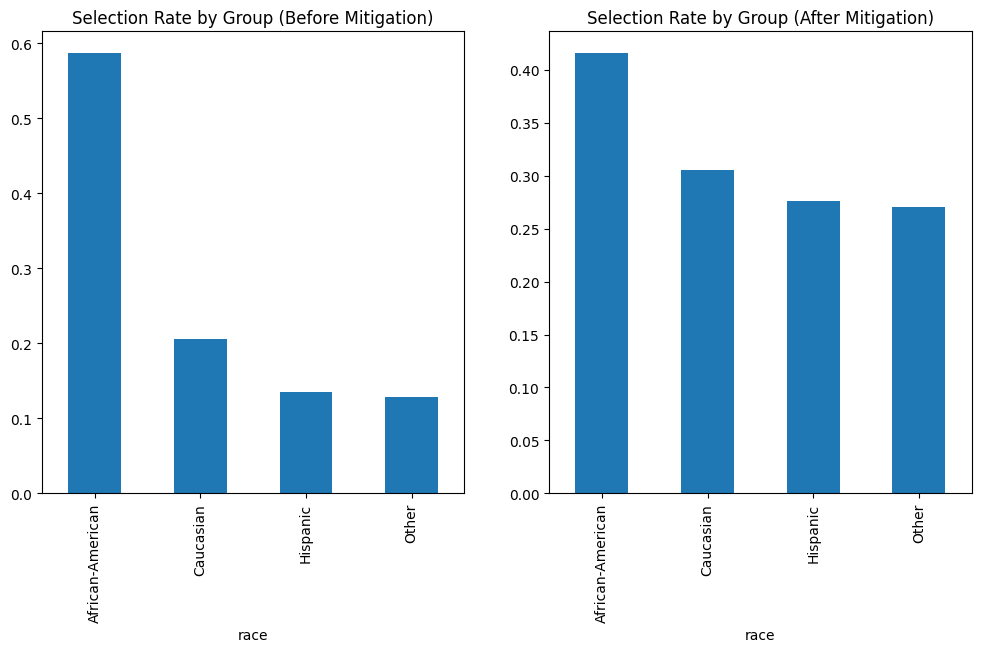

In [54]:
# Plot selection rate for each group before and after mitigation
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
metric_frame2.by_group['selection_rate'].plot(kind='bar', ax=ax[0], title='Selection Rate by Group (Before Mitigation)')
metric_frame_mitigated2.by_group['selection_rate'].plot(kind='bar', ax=ax[1], title='Selection Rate by Group (After Mitigation)')
plt.show()

C:\Users\ojoak\AppData\Local\Temp\ipykernel_24368\658489469.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[0].vlines(x=metric_frame2.by_group.index[i], ymin=0, ymax=metric_frame2.by_group['selection_rate'][i], colors='b', linestyles='-',linewidth=2.5)
C:\Users\ojoak\AppData\Local\Temp\ipykernel_24368\658489469.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[1].vlines(x=metric_frame_mitigated2.by_group.index[i], ymin=0, ymax=metric_frame_mitigated2.by_group['selection_rate'][i], colors='r', linestyles='-',linewidth=2.5)


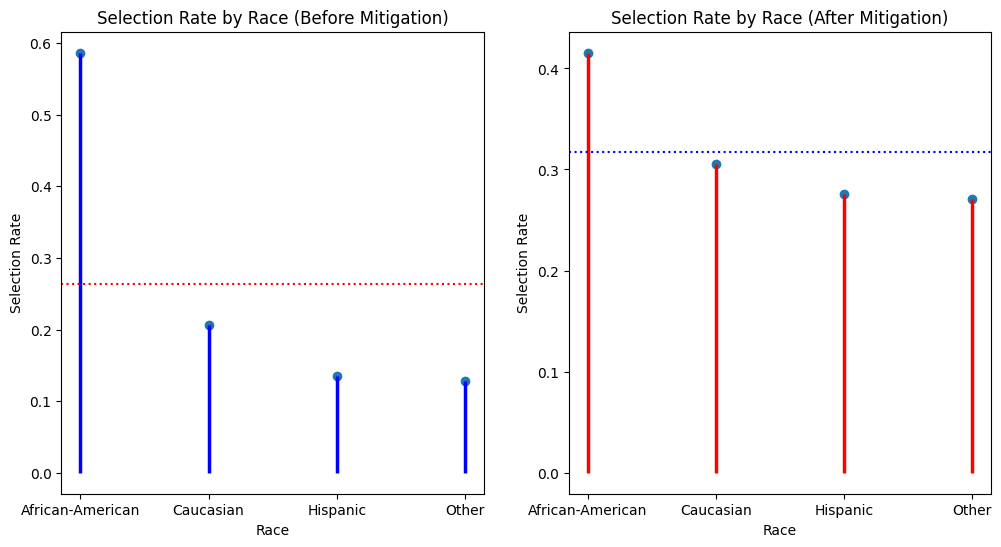

In [55]:
# Plot selection rate for each race before and after mitigation as dot plots with vertical lines for each race
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Calculate mean selection rates
mean_selection_rate_before2 = metric_frame2.by_group['selection_rate'].mean()
mean_selection_rate_after2 = metric_frame_mitigated2.by_group['selection_rate'].mean()

# Plot before mitigation
ax[0].plot(metric_frame.by_group.index, metric_frame2.by_group['selection_rate'], 'o', label='Before Mitigation')
for i in range(len(metric_frame2.by_group.index)):
    ax[0].vlines(x=metric_frame2.by_group.index[i], ymin=0, ymax=metric_frame2.by_group['selection_rate'][i], colors='b', linestyles='-',linewidth=2.5)
ax[0].axhline(y=mean_selection_rate_before2, color='r', linestyle='dotted', label='Mean Selection Rate')
ax[0].set_title('Selection Rate by Race (Before Mitigation)')
ax[0].set_xlabel('Race')
ax[0].set_ylabel('Selection Rate')

# Plot after mitigation
ax[1].plot(metric_frame_mitigated2.by_group.index, metric_frame_mitigated2.by_group['selection_rate'], 'o', label='After Mitigation')
for i in range(len(metric_frame_mitigated2.by_group.index)):
    ax[1].vlines(x=metric_frame_mitigated2.by_group.index[i], ymin=0, ymax=metric_frame_mitigated2.by_group['selection_rate'][i], colors='r', linestyles='-',linewidth=2.5)
ax[1].axhline(y=mean_selection_rate_after2, color='b', linestyle='dotted', label='Mean Selection Rate')
ax[1].set_title('Selection Rate by Race (After Mitigation)')
ax[1].set_xlabel('Race')
ax[1].set_ylabel('Selection Rate')


# Save the plot to a PDF file
#plt.subplots_adjust(bottom=0.4)
pdf = matplotlib.backends.backend_pdf.PdfPages("Selection_rate_case1b.pdf")
pdf.savefig(plt.gcf())
pdf.close()

#plt.legend()
plt.show()

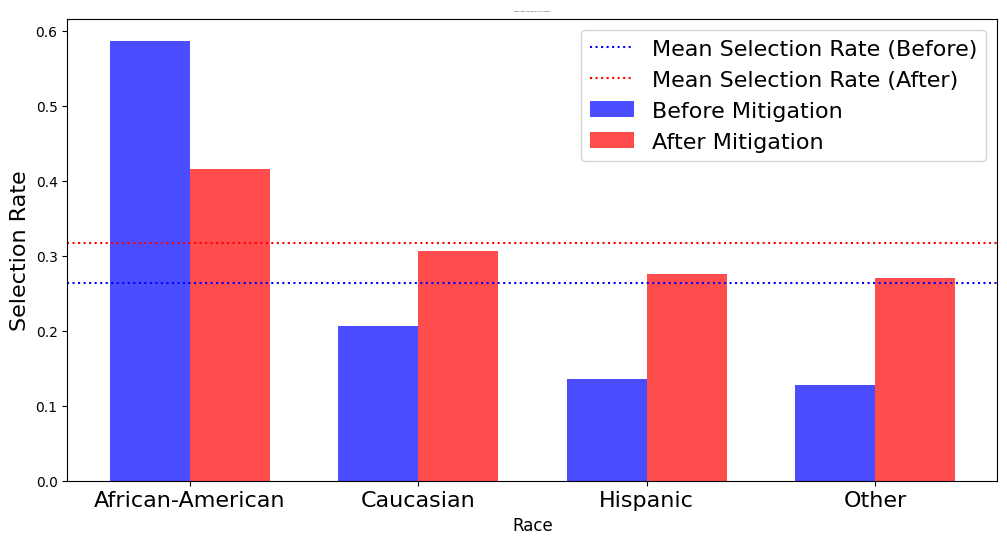

In [68]:
# Plot selection rate for each race before and after mitigation as a multiple bar chart
fig, ax = plt.subplots(figsize=(12, 6))

# Calculate mean selection rates
mean_selection_rate_before2 = metric_frame2.by_group['selection_rate'].mean()
mean_selection_rate_after2 = metric_frame_mitigated2.by_group['selection_rate'].mean()

# Get the races and their corresponding selection rates
races = metric_frame2.by_group.index
selection_rates_before2 = metric_frame2.by_group['selection_rate']
selection_rates_after2 = metric_frame_mitigated2.by_group['selection_rate']

# Set the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
x = np.arange(len(races))

# Plot the bars for before and after mitigation
ax.bar(x - bar_width/2, selection_rates_before2, width=bar_width, label='Before Mitigation', color='b', alpha=0.7)
ax.bar(x + bar_width/2, selection_rates_after2, width=bar_width, label='After Mitigation', color='r', alpha=0.7)

# Add horizontal lines for the mean selection rates
ax.axhline(y=mean_selection_rate_before2, color='b', linestyle='dotted', label='Mean Selection Rate (Before)')
ax.axhline(y=mean_selection_rate_after2, color='r', linestyle='dotted', label='Mean Selection Rate (After)')

# Set the x-axis labels and title
ax.set_xticks(x)
ax.set_xticklabels(races,fontsize=16)
ax.set_xlabel('Race',fontsize=12)
ax.set_ylabel('Selection Rate',fontsize=16)
ax.set_title('Selection Rate by Race (Before and After Mitigation)',fontsize=1)

# Add a legend
ax.legend(fontsize=16)

# Save the plot to a PDF file
pdf = matplotlib.backends.backend_pdf.PdfPages("Selection_rate_case1b_bar_chart.pdf")
pdf.savefig(fig)
pdf.close()

# Show the plot
plt.show()

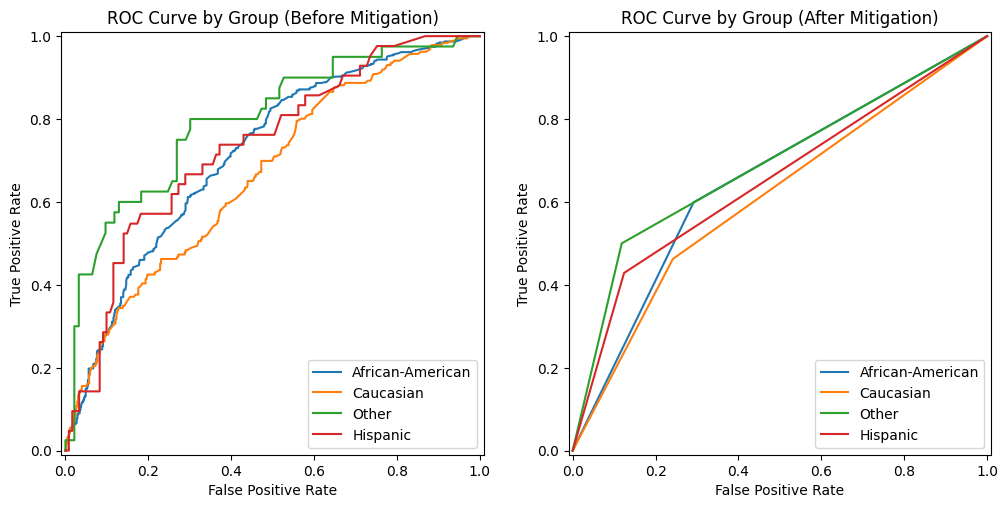

In [80]:
# Plot ROC curves for each group before and after mitigation
groups = sensitive_test.unique()
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for group in groups:
    group_mask = (sensitive_test == group)
    if group_mask.sum() > 0:  # Ensure there are samples for the group
        fpr, tpr, _ = roc_curve(y_test2[group_mask], y_pred_proba[group_mask])
        RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax[0], name=f'{group}')
        fpr_mitigated, tpr_mitigated, _ = roc_curve(y_test2[group_mask], y_pred_mitigated_proba[group_mask])
        RocCurveDisplay(fpr=fpr_mitigated, tpr=tpr_mitigated).plot(ax=ax[1], name=f'{group}')

ax[0].set_title('ROC Curve by Group (Before Mitigation)')
ax[1].set_title('ROC Curve by Group (After Mitigation)')

# Save the plot to a PDF file
#plt.subplots_adjust(bottom=0.4)
pdf = matplotlib.backends.backend_pdf.PdfPages("ROC_case1b.pdf")
pdf.savefig(plt.gcf())
pdf.close()

plt.show()

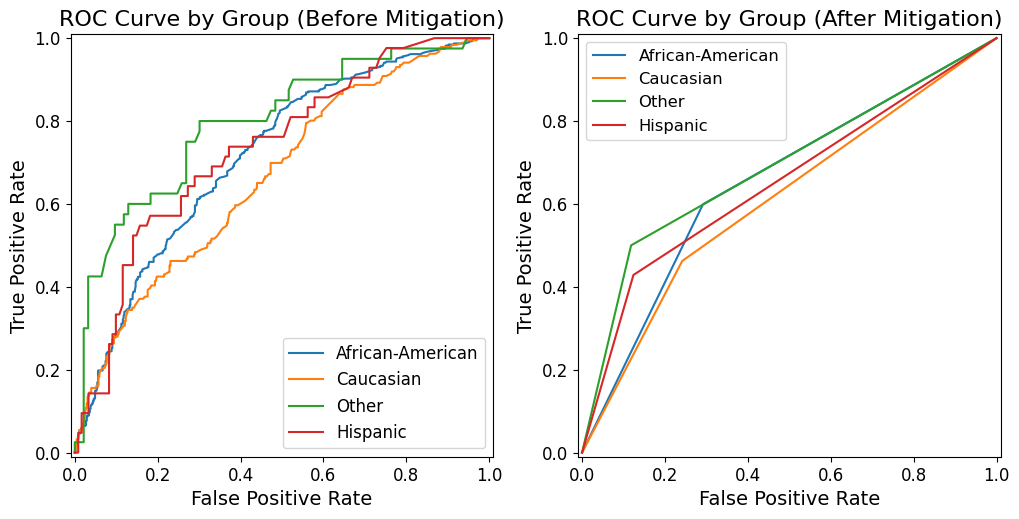

In [86]:
# Plot ROC curves for each group before and after mitigation
groups = sensitive_test.unique()
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for group in groups:
    group_mask = (sensitive_test == group)
    if group_mask.sum() > 0:  # Ensure there are samples for the group
        fpr, tpr, _ = roc_curve(y_test2[group_mask], y_pred_proba[group_mask])
        RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax[0], name=f'{group}')
        fpr_mitigated, tpr_mitigated, _ = roc_curve(y_test2[group_mask], y_pred_mitigated_proba[group_mask])
        RocCurveDisplay(fpr=fpr_mitigated, tpr=tpr_mitigated).plot(ax=ax[1], name=f'{group}')

ax[0].set_title('ROC Curve by Group (Before Mitigation)', fontsize=16)
ax[1].set_title('ROC Curve by Group (After Mitigation)', fontsize=16)

# Increase font size for x and y labels
ax[0].set_xlabel('False Positive Rate', fontsize=14)
ax[0].set_ylabel('True Positive Rate', fontsize=14)
ax[1].set_xlabel('False Positive Rate', fontsize=14)
ax[1].set_ylabel('True Positive Rate', fontsize=14)

# Increase font size for tick labels
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[1].tick_params(axis='both', which='major', labelsize=12)

# Increase font size for legend
ax[0].legend(fontsize=12)
ax[1].legend(fontsize=11.8)

# Save the plot to a PDF file
pdf = matplotlib.backends.backend_pdf.PdfPages("ROC_case1b.pdf")
pdf.savefig(plt.gcf())
pdf.close()

plt.show()

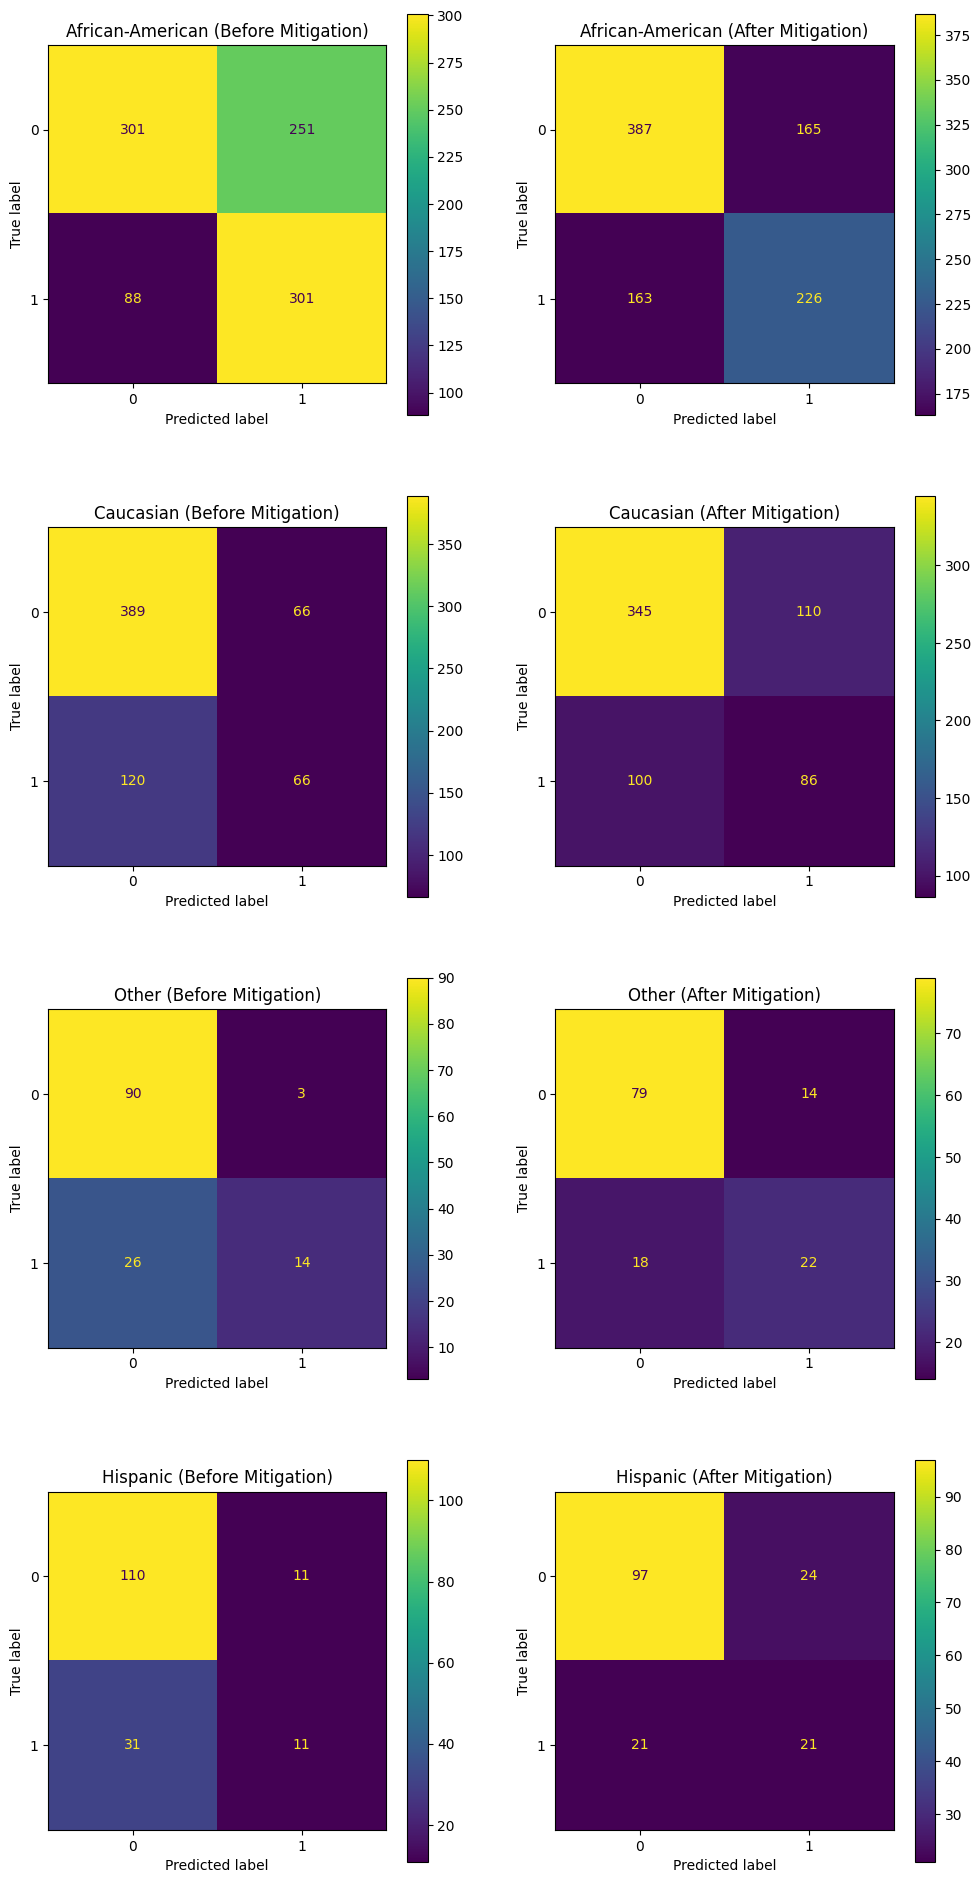

In [91]:
# Generate confusion matrices for each group before and after mitigation
fig, ax = plt.subplots(len(groups), 2, figsize=(12, 6 * len(groups)))

for i, group in enumerate(groups):
    group_mask = (sensitive_test == group)
    if group_mask.sum() > 0:  # Ensure there are samples for the group
        cm_before = confusion_matrix(y_test2[group_mask], y_pred2[group_mask])
        cm_display_before = ConfusionMatrixDisplay(confusion_matrix=cm_before)
        cm_display_before.plot(ax=ax[i][0])
        ax[i][0].set_title(f'{group} (Before Mitigation)')

        cm_after = confusion_matrix(y_test2[group_mask], y_pred_mitigated[group_mask])
        cm_display_after = ConfusionMatrixDisplay(confusion_matrix=cm_after)
        cm_display_after.plot(ax=ax[i][1])
        ax[i][1].set_title(f'{group} (After Mitigation)')

plt.show()

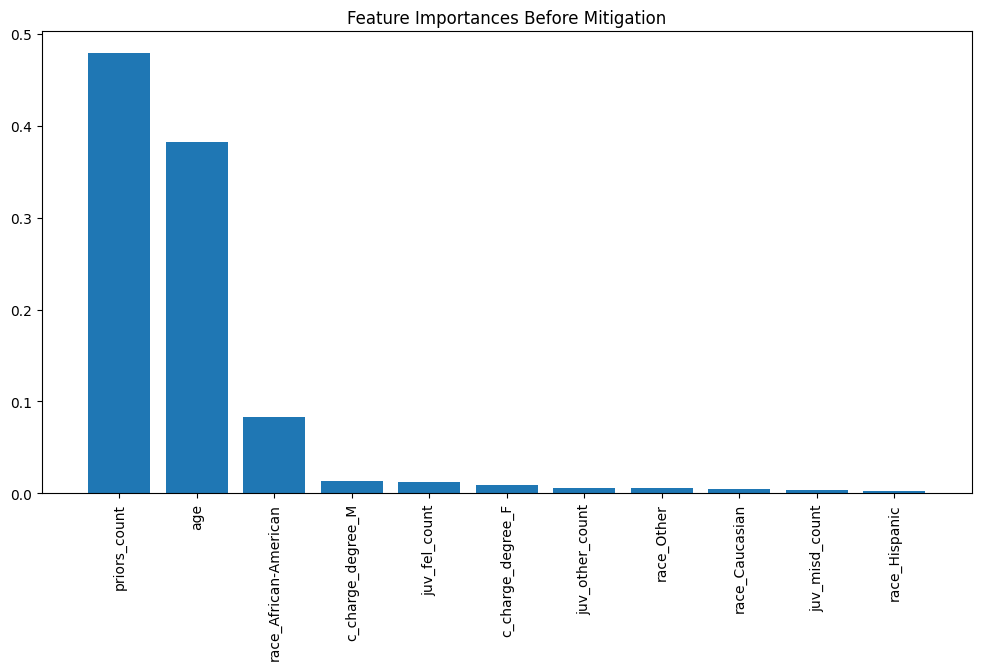

In [92]:
# Plot VIP (Variable Importance Plot) for the model before mitigation
feature_importances_before = model.feature_importances_
indices_before = np.argsort(feature_importances_before)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importances Before Mitigation")
plt.bar(range(X0.shape[1]), feature_importances_before[indices_before], align="center")
plt.xticks(range(X0.shape[1]), X0.columns[indices_before], rotation=90)
plt.xlim([-1, X0.shape[1]])
plt.show()

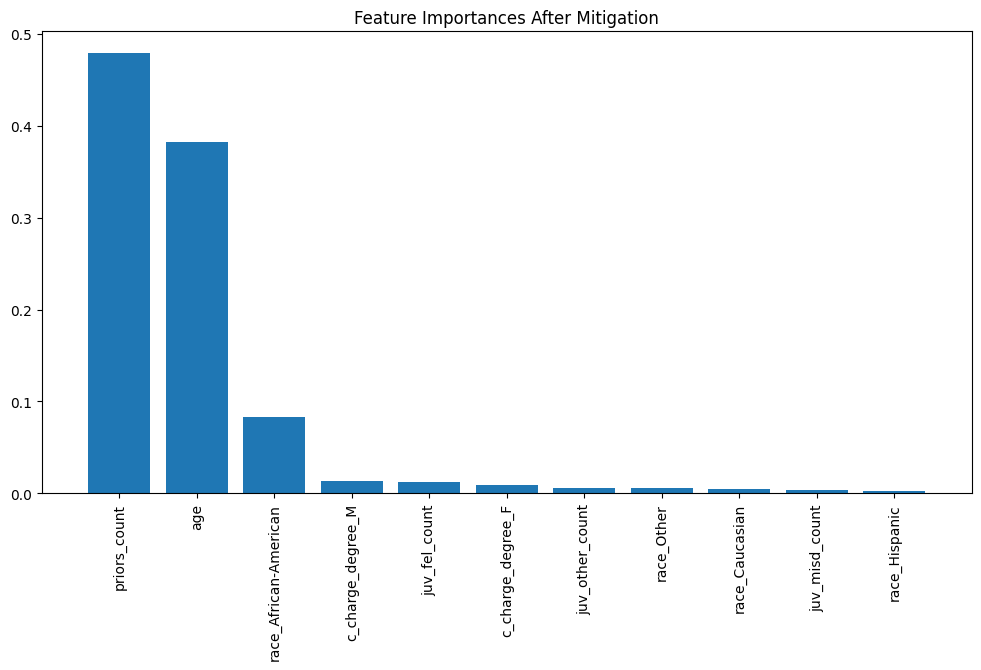

In [93]:
# Plot VIP (Variable Importance Plot) for the model after mitigation
feature_importances_after2 = threshold_optimizer.estimator_.feature_importances_
indices_after2 = np.argsort(feature_importances_after2)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importances After Mitigation")
plt.bar(range(X0.shape[1]), feature_importances_after2[indices_after2], align="center")
plt.xticks(range(X0.shape[1]), X0.columns[indices_after2], rotation=90)
plt.xlim([-1, X0.shape[1]])
plt.show()

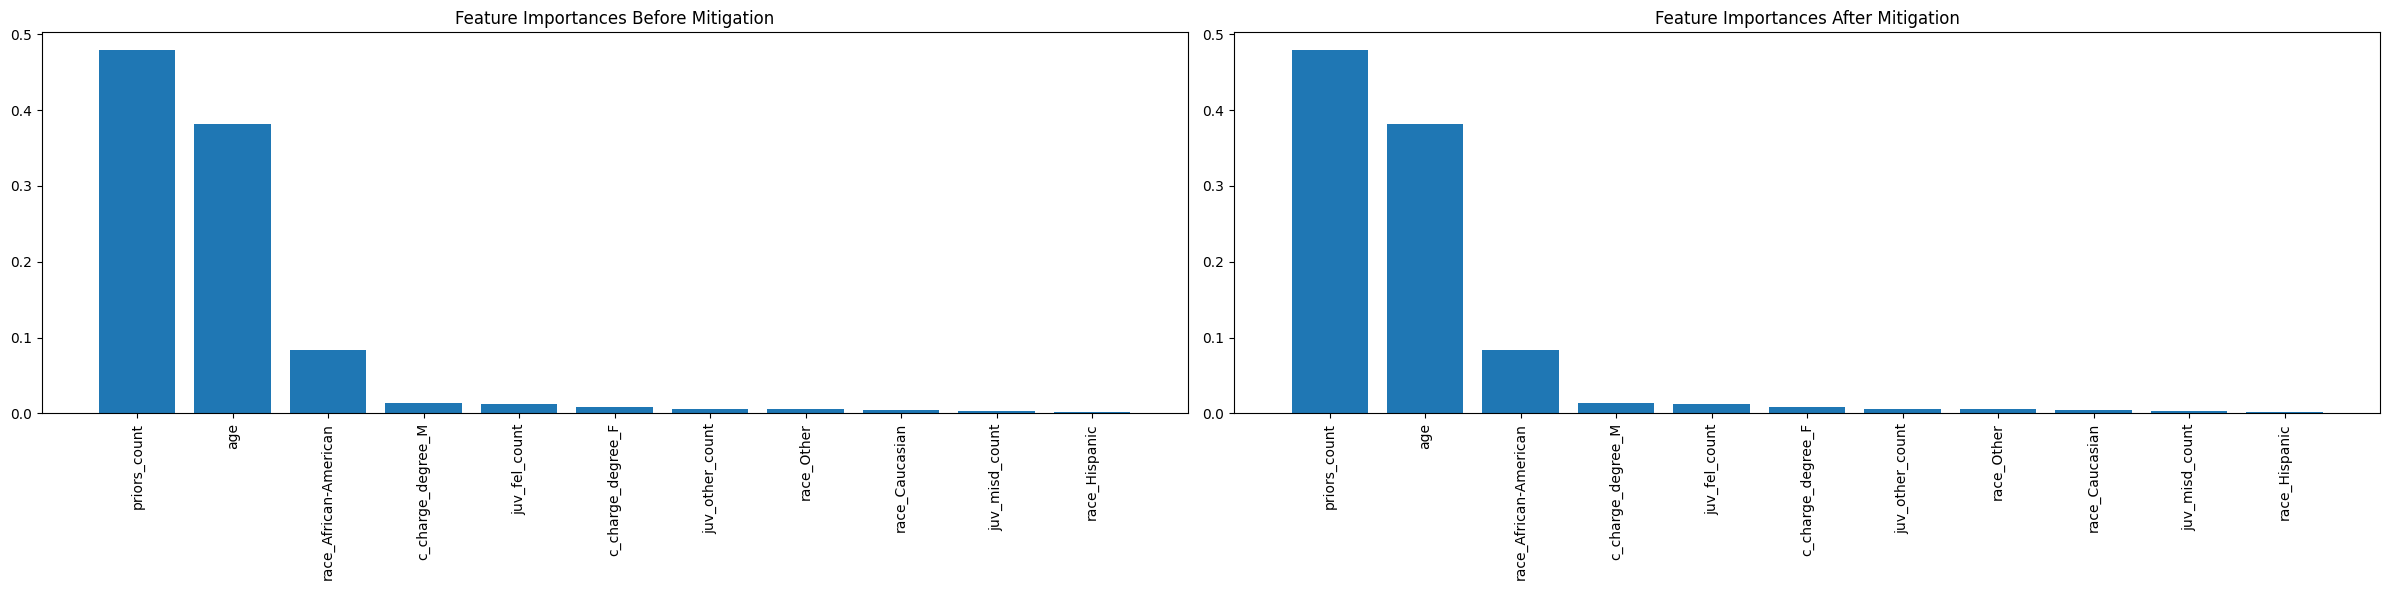

In [94]:

# side-by-side plot
feature_importances_before = model.feature_importances_
indices_before = np.argsort(feature_importances_before)[::-1]

feature_importances_after2 = threshold_optimizer.estimator_.feature_importances_
indices_after2 = np.argsort(feature_importances_after2)[::-1]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))

# Plot for the model before mitigation
axes[0].bar(range(X0.shape[1]), feature_importances_before[indices_before], align="center")
axes[0].set_title("Feature Importances Before Mitigation")
axes[0].set_xticks(range(X0.shape[1]))
axes[0].set_xticklabels(X0.columns[indices_before], rotation=90)
axes[0].set_xlim([-1, X0.shape[1]])

# Plot for the model after mitigation
axes[1].bar(range(X0.shape[1]), feature_importances_after2[indices_after2], align="center")
axes[1].set_title("Feature Importances After Mitigation")
axes[1].set_xticks(range(X0.shape[1]))
axes[1].set_xticklabels(X0.columns[indices_after2], rotation=90)
axes[1].set_xlim([-1, X0.shape[1]])

plt.tight_layout()  # Adjust subplots to fit into figure area.

# Save the plot to a PDF file
#plt.subplots_adjust(bottom=0.4)
pdf = matplotlib.backends.backend_pdf.PdfPages("VIPb_case2b.pdf")
pdf.savefig(plt.gcf())
pdf.close()
plt.show()


In [95]:
# Make predictions before mitigation
y_pred_before2 = model.predict(X_test2)
y_pred_proba_before2 = model.predict_proba(X_test2)[:, 1]

In [96]:
# Mitigate bias using ThresholdOptimizer with Equalized Odds
threshold_optimizer2 = ThresholdOptimizer(estimator=model, constraints="equalized_odds", prefit=True)
threshold_optimizer2.fit(X_train2, y_train2, sensitive_features=sensitive_train)
y_pred_after2 = threshold_optimizer2.predict(X_test2, sensitive_features=sensitive_test)
y_pred_proba_after2 = threshold_optimizer2.predict(X_test2, sensitive_features=sensitive_test)

In [97]:
# Calculate classifier probability scores for false positives and false negatives for each sample for all races before and after mitigation
false_positives_before2 = (y_test2 == 0) & (y_pred_before2 == 1)
false_negatives_before2 = (y_test2 == 1) & (y_pred_before2 == 0)

false_positives_after2 = (y_test2 == 0) & (y_pred_after2 == 1)
false_negatives_after2 = (y_test2 == 1) & (y_pred_after2 == 0)

In [98]:
# Create a DataFrame to store the results before and after mitigation
results_df_before2 = pd.DataFrame({
    'Race': sensitive_test,
    'True Label': y_test2,
    'Predicted Label': y_pred_before2,
    'Probability Score': y_pred_proba_before2,
    'False Positive': false_positives_before2,
    'False Negative': false_negatives_before2,
    'False Positive Score': np.where(false_positives_before2, y_pred_proba_before2, np.nan),
    'False Negative Score': np.where(false_negatives_before2, y_pred_proba_before2, np.nan),
    'Mitigation': 'Before'
})

In [99]:
results_df_after2 = pd.DataFrame({
    'Race': sensitive_test,
    'True Label': y_test2,
    'Predicted Label': y_pred_after2,
    'Probability Score': y_pred_proba_after2,
    'False Positive': false_positives_after2,
    'False Negative': false_negatives_after2,
    'False Positive Score': np.where(false_positives_after2, y_pred_proba_after2, np.nan),
    'False Negative Score': np.where(false_negatives_after2, y_pred_proba_after2, np.nan),
    'Mitigation': 'After'
})

In [100]:
# Concatenate the results DataFrames
results_df2 = pd.concat([results_df_before2, results_df_after2])

In [67]:
# Save the results to a CSV file
results_df2.to_csv('classifier_probability_scores_mitigationLessbiasedCase1.csv', index=False)

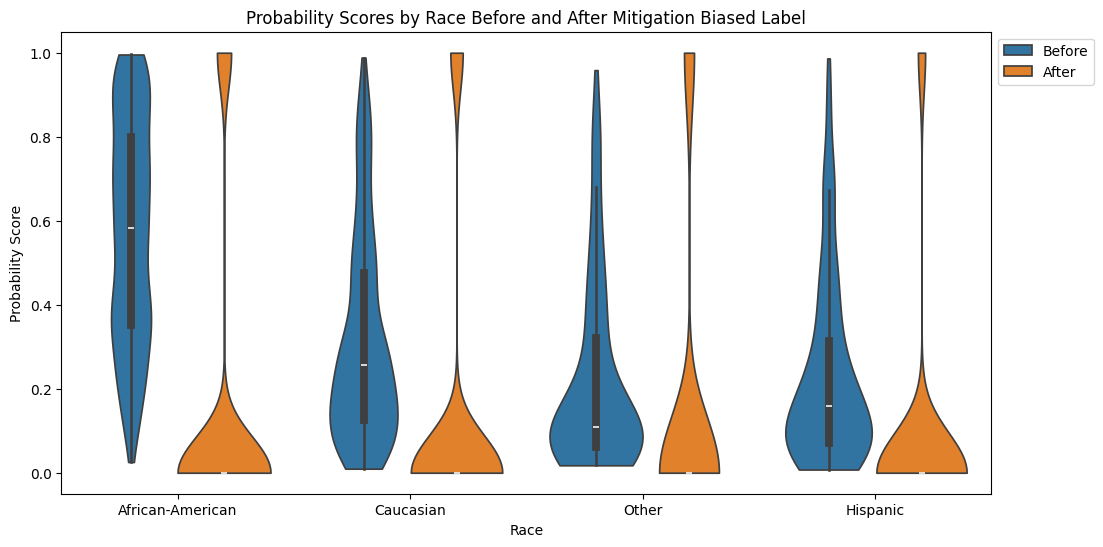

In [101]:
import seaborn as sns


# Plot a violin plot for probability scores by race before and after mitigation
plt.figure(figsize=(12, 6))
sns.violinplot(x='Race', y='Probability Score', hue='Mitigation', data=results_df2, inner='box', cut=0)
plt.title('Probability Scores by Race Before and After Mitigation Biased Label')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# Save the plot to a PDF file
#plt.subplots_adjust(bottom=0.4)
pdf = matplotlib.backends.backend_pdf.PdfPages("ProbScore_case1b.pdf")
pdf.savefig(plt.gcf())
pdf.close()
plt.show()



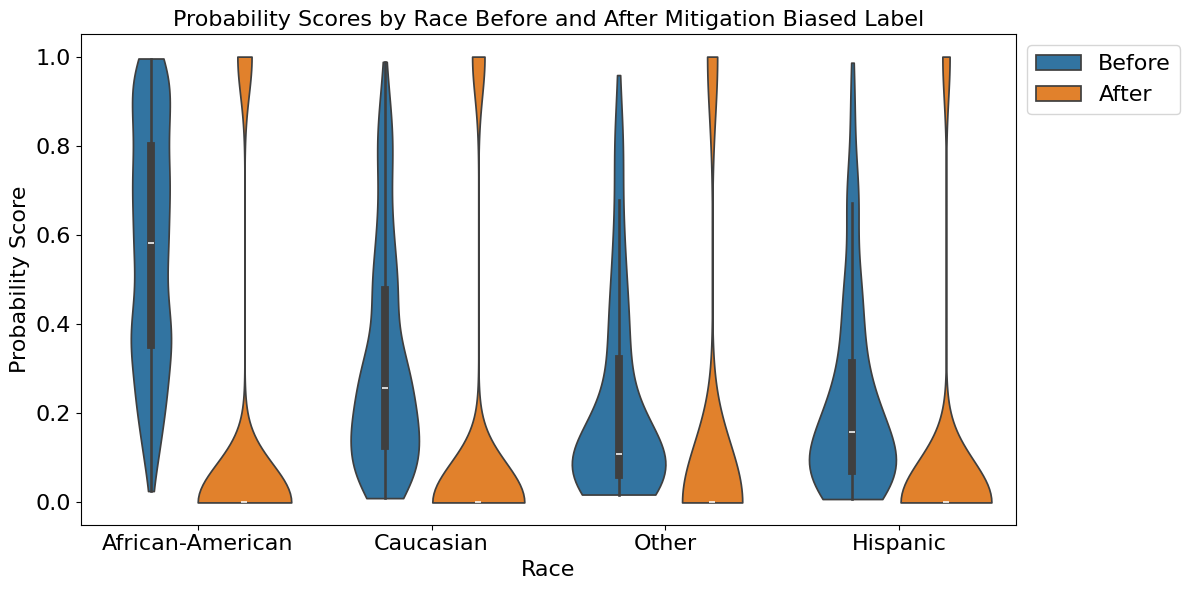

In [148]:
# Plot a violin plot for probability scores by race before and after mitigation
plt.figure(figsize=(12, 6))

# Create the violin plot
sns.violinplot(x='Race', y='Probability Score', hue='Mitigation', data=results_df2, inner='box', cut=0)

# Increase font size for the title
plt.title('Probability Scores by Race Before and After Mitigation Biased Label', fontsize=16)

# Increase font size for x and y labels
plt.xlabel('Race', fontsize=16)
plt.ylabel('Probability Score', fontsize=16)

# Increase font size for tick labels
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Increase font size for the legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=16)

# Adjust layout to prevent cutting off
plt.tight_layout()

# Save the plot to a PDF file
pdf = matplotlib.backends.backend_pdf.PdfPages("ProbScore_case1bF.pdf")
pdf.savefig(plt.gcf())
pdf.close()

plt.show()

C:\Users\ojoak\AppData\Local\Temp\ipykernel_24368\2384612386.py:8: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.violinplot(x='Race', y='Probability Score', hue='Mitigation', data=results_df2, inner='box', cut=0, palette=bright_palette)


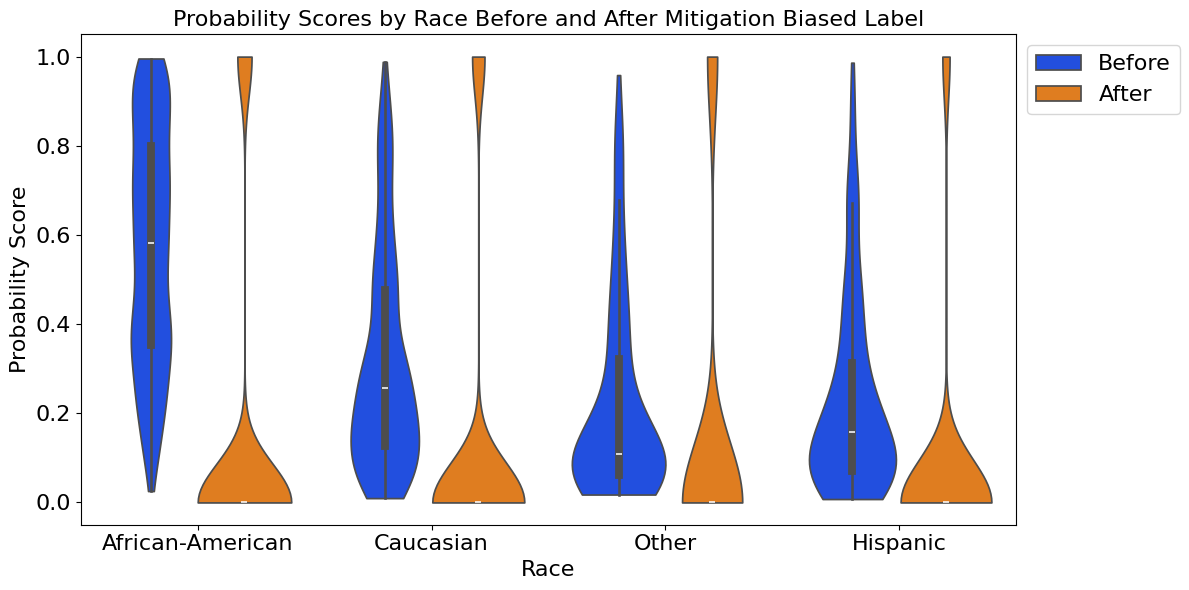

In [151]:
# Plot a violin plot for probability scores by race before and after mitigation
plt.figure(figsize=(12, 6))

# Use a bright color palette
bright_palette = sns.color_palette("bright")

# Create the violin plot with the bright color palette
sns.violinplot(x='Race', y='Probability Score', hue='Mitigation', data=results_df2, inner='box', cut=0, palette=bright_palette)

# Increase font size for the title
plt.title('Probability Scores by Race Before and After Mitigation Biased Label', fontsize=16)

# Increase font size for x and y labels
plt.xlabel('Race', fontsize=16)
plt.ylabel('Probability Score', fontsize=16)

# Increase font size for tick labels
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Increase font size for the legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=16)

# Adjust layout to prevent cutting off
plt.tight_layout()

# Save the plot to a PDF file
pdf = matplotlib.backends.backend_pdf.PdfPages("ProbScore_case1bFb.pdf")
pdf.savefig(plt.gcf())
pdf.close()

plt.show()

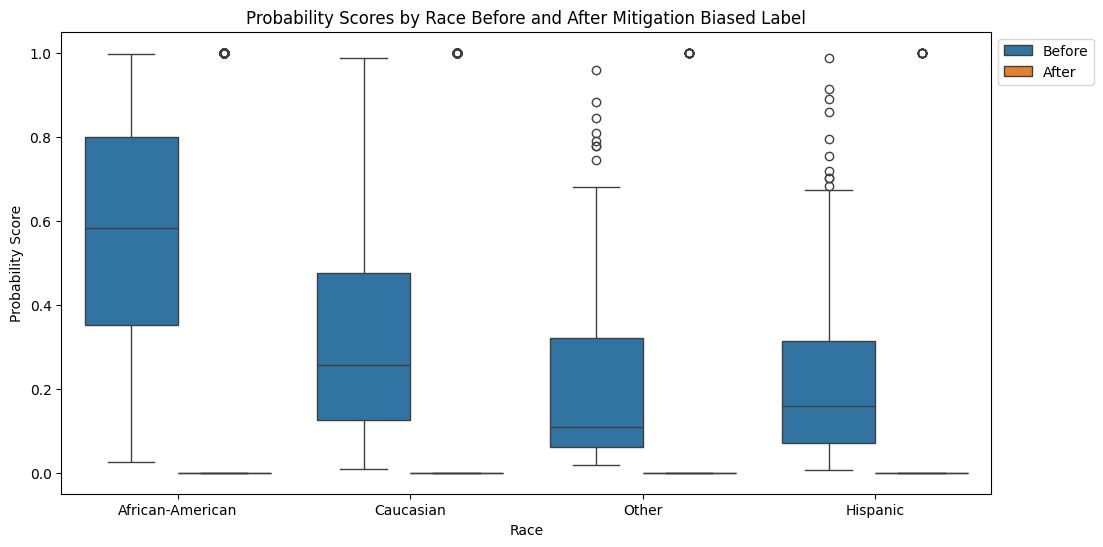

In [69]:
# Plot a boxplot for probability scores by race before and after mitigation
plt.figure(figsize=(12, 6))
sns.boxplot(x='Race', y='Probability Score', hue='Mitigation', data=results_df2)
plt.title('Probability Scores by Race Before and After Mitigation Biased Label')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [761]:
##############################################################################################################################################

In [762]:
#     #################################################                       FAIRNESS METRIC 

In [70]:
def calculate_independence_per_group(metrics_df_before2):
  """
  Calculates independence Odds Difference for each group in the DataFrame.

  Args:
    metrics_df: pandas DataFrame with columns: 'Race', 'TPR', 'FPR' 

  Returns:
    pandas DataFrame with independence Odds Difference for each group.
  """

  groups = metrics_df_before2['Race'].unique()
  results = []

  for group in groups:
    group_data = metrics_df_before2[metrics_df_before2['Race'] == group] 
    group_select = group_data['Selection'].values[0]
    #group_fpr = group_data['FPR'].values[0]

    independence2_odds_diffs = []
    for other_group in groups:
      if group == other_group:
        continue  # Don't compare self

      other_group_data = metrics_df_before2[metrics_df_before2['Race'] == other_group]
      other_group_select = other_group_data['Selection'].values[0]
      #other_group_fpr = other_group_data['FPR'].values[0]

      diff = abs(group_select - other_group_select) #+ abs(group_fpr - other_group_fpr)
      independence2_odds_diffs.append(diff)

    results.append({'Race': group, 'independence Odds Diff': max(independence2_odds_diffs)})

  return pd.DataFrame(results)

# Sample DataFrame
metrics_df_before2_before = pd.DataFrame({
    'Race': ['African-American', 'Caucasian', 'Hispanic','Other'],
    'Selection': [0.5866,0.2059,0.1350,0.1278]
})

independence2_odds_per_group = calculate_independence_per_group(metrics_df_before2_before)
print("independence Odds Difference per Group:")
print(independence2_odds_per_group)

independence Odds Difference per Group:
               Race  independence Odds Diff
0  African-American                  0.4588
1         Caucasian                  0.3807
2          Hispanic                  0.4516
3             Other                  0.4588


In [71]:
def calculate_equalized_odds_per_group(metrics_df):
  """
  Calculates Equalized Odds Difference for each group in the DataFrame.

  Args:
    metrics_df: pandas DataFrame with columns: 'Race', 'TPR', 'FPR' 

  Returns:
    pandas DataFrame with Equalized Odds Difference for each group.
  """

  groups = metrics_df_before2['Race'].unique()
  results = []

  for group in groups:
    group_data = metrics_df_before2[metrics_df_before2['Race'] == group] 
    group_tpr = group_data['TPR'].values[0]
    group_fpr = group_data['FPR'].values[0]

    equalized_odds_diffs = []
    for other_group in groups:
      if group == other_group:
        continue  # Don't compare self

      other_group_data = metrics_df_before2[metrics_df_before2['Race'] == other_group]
      other_group_tpr = other_group_data['TPR'].values[0]
      other_group_fpr = other_group_data['FPR'].values[0]

      diff = abs(group_tpr - other_group_tpr) + abs(group_fpr - other_group_fpr)
      equalized_odds_diffs.append(diff)

    results.append({'Race': group, 'Equalized Odds Diff': max(equalized_odds_diffs)})

  return pd.DataFrame(results)

# Sample DataFrame
metrics_df_before2 = pd.DataFrame({
    'Race': ['African-American', 'Caucasian', 'Hispanic','Other'],
    'TPR': [0.7738,0.3548,0.2619,0.3500],
    'FPR': [0.4547,0.1451,0.0909,0.0323]
})

equalized_odds_per_group2 = calculate_equalized_odds_per_group(metrics_df_before2)
print("Equalized Odds Difference per Group:")
print(equalized_odds_per_group2)

Equalized Odds Difference per Group:
               Race  Equalized Odds Diff
0  African-American               0.8757
1         Caucasian               0.7286
2          Hispanic               0.8757
3             Other               0.8462


In [72]:
def calculate_sufficiency_per_group(metrics_df):
  """
  Calculates Sufficiency Difference for each group in the DataFrame.

  Args:
    metrics_df: pandas DataFrame with columns: 'Race', 'PPV', 'NPV' 

  Returns:
    pandas DataFrame with Sufficiency Difference for each group.
  """

  groups = metrics_df_before2['Race'].unique()
  results = []

  for group in groups:
    group_data = metrics_df_before2[metrics_df_before2['Race'] == group] 
    group_ppv = group_data['PPV'].values[0]
    group_npv = group_data['NPV'].values[0]

    sufficiency_diffs = []
    for other_group in groups:
      if group == other_group:
        continue  # Skip comparison with itself

      other_group_data = metrics_df_before2[metrics_df_before2['Race'] == other_group]
      other_group_ppv = other_group_data['PPV'].values[0]
      other_group_npv = other_group_data['NPV'].values[0]

      diff = abs(group_ppv - other_group_ppv) + abs(group_npv - other_group_npv)
      sufficiency_diffs.append(diff)

    results.append({'Race': group, 'Sufficiency Diff': max(sufficiency_diffs)})

  return pd.DataFrame(results)

# Sample DataFrame (assuming you have PPV and NPV columns)
metrics_df_before2 = pd.DataFrame({
    'Race': ['African-American', 'Caucasian', 'Hispanic','Other'],
    'PPV': [0.5453,0.5000,0.5000,0.8235],
    'NPV': [0.7738,0.7642,0.7801,0.7759]
})

sufficiency_per_group = calculate_sufficiency_per_group(metrics_df_before2)
print("Sufficiency Difference per Group:")
print(sufficiency_per_group)

Sufficiency Difference per Group:
               Race  Sufficiency Diff
0  African-American            0.2803
1         Caucasian            0.3352
2          Hispanic            0.3277
3             Other            0.3352


In [73]:
def calculate_independence_per_group(metrics_df_after2):
  """
  Calculates independence Odds Difference for each group in the DataFrame.

  Args:
    metrics_df: pandas DataFrame with columns: 'Race', 'TPR', 'FPR' 

  Returns:
    pandas DataFrame with independence Odds Difference for each group.
  """

  groups = metrics_df_after2['Race'].unique()
  results = []

  for group in groups:
    group_data = metrics_df_after2[metrics_df_after2['Race'] == group] 
    group_select = group_data['Selection'].values[0]
    #group_fpr = group_data['FPR'].values[0]

    independence_after2_diffs = []
    for other_group in groups:
      if group == other_group:
        continue  # Don't compare self

      other_group_data = metrics_df_after2[metrics_df_after2['Race'] == other_group]
      other_group_select = other_group_data['Selection'].values[0]
      #other_group_fpr = other_group_data['FPR'].values[0]

      diff = abs(group_select - other_group_select) #+ abs(group_fpr - other_group_fpr)
      independence_after2_diffs.append(diff)

    results.append({'Race': group, 'independence Odds Diff': max(independence_after2_diffs)})

  return pd.DataFrame(results)

# Sample DataFrame
metrics_df_after2 = pd.DataFrame({
    'Race': ['African-American', 'Caucasian', 'Hispanic','Other'],
    'Selection': [0.4123,0.3058,0.2270,0.2481]
})

independence_after2_per_group = calculate_independence_per_group(metrics_df_after2)
print("independence Odds Difference per Group:")
print(independence_after2_per_group)

independence Odds Difference per Group:
               Race  independence Odds Diff
0  African-American                  0.1853
1         Caucasian                  0.1065
2          Hispanic                  0.1853
3             Other                  0.1642


In [74]:
def calculate_equalized_odds_per_group(metrics_df):
  """
  Calculates Equalized Odds Difference for each group in the DataFrame.

  Args:
    metrics_df: pandas DataFrame with columns: 'Race', 'TPR', 'FPR' 

  Returns:
    pandas DataFrame with Equalized Odds Difference for each group.
  """

  groups = metrics_df_after2['Race'].unique()
  results = []

  for group in groups:
    group_data = metrics_df_after2[metrics_df_after2['Race'] == group] 
    group_tpr = group_data['TPR'].values[0]
    group_fpr = group_data['FPR'].values[0]

    equalized_odds_diffs = []
    for other_group in groups:
      if group == other_group:
        continue  # Don't compare self

      other_group_data = metrics_df_after2[metrics_df_after2['Race'] == other_group]
      other_group_tpr = other_group_data['TPR'].values[0]
      other_group_fpr = other_group_data['FPR'].values[0]

      diff = abs(group_tpr - other_group_tpr) + abs(group_fpr - other_group_fpr)
      equalized_odds_diffs.append(diff)

    results.append({'Race': group, 'Equalized Odds Diff': max(equalized_odds_diffs)})

  return pd.DataFrame(results)

# Sample DataFrame
metrics_df_after2 = pd.DataFrame({
    'Race': ['African-American', 'Caucasian', 'Hispanic', 'Other'],
    'TPR': [0.5758,0.4624,0.4524,0.6000],
    'FPR': [0.2971,0.2418,0.1488,0.0968]
})

equalized_odds_per_group2_after = calculate_equalized_odds_per_group(metrics_df_after2)
print("Equalized Odds Difference per Group:")
print(equalized_odds_per_group2_after)

Equalized Odds Difference per Group:
               Race  Equalized Odds Diff
0  African-American               0.2717
1         Caucasian               0.2826
2          Hispanic               0.2717
3             Other               0.2826


In [75]:
def calculate_sufficiency_per_group(metrics_df):
  """
  Calculates Sufficiency Difference for each group in the DataFrame.

  Args:
    metrics_df: pandas DataFrame with columns: 'Race', 'PPV', 'NPV' 

  Returns:
    pandas DataFrame with Sufficiency Difference for each group.
  """

  groups = metrics_df_after2['Race'].unique()
  results = []

  for group in groups:
    group_data = metrics_df_after2[metrics_df_after2['Race'] == group] 
    group_ppv = group_data['PPV'].values[0]
    group_npv = group_data['NPV'].values[0]

    sufficiency_diffs = []
    for other_group in groups:
      if group == other_group:
        continue  # Skip comparison with itself

      other_group_data = metrics_df_after2[metrics_df_after2['Race'] == other_group]
      other_group_ppv = other_group_data['PPV'].values[0]
      other_group_npv = other_group_data['NPV'].values[0]

      diff = abs(group_ppv - other_group_ppv) + abs(group_npv - other_group_npv)
      sufficiency_diffs.append(diff)

    results.append({'Race': group, 'Sufficiency Diff': max(sufficiency_diffs)})

  return pd.DataFrame(results)

# Sample DataFrame (assuming you have PPV and NPV columns)
metrics_df_after2 = pd.DataFrame({
    'Race': ['African-American', 'Caucasian', 'Hispanic','Other'],
    'PPV': [0.5773,0.4385,0.5135,0.7273],
    'NPV': [0.7016,0.7753,0.8175,0.8400]
})

sufficiency_per_group_after = calculate_sufficiency_per_group(metrics_df_after2)
print("Sufficiency Difference per Group:")
print(sufficiency_per_group_after)

Sufficiency Difference per Group:
               Race  Sufficiency Diff
0  African-American            0.2884
1         Caucasian            0.3535
2          Hispanic            0.2363
3             Other            0.3535


In [ ]:
#....                                                End case 1

In [ ]:
##############################################################################################################################################